# Artificial Neural Network Forecasting (Previous Day)

In [1]:
import os
import sys
import glob
import time
import pytz
import datetime as dt
import dateutil
from itertools import chain
from cycler import cycler
from io import StringIO


import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pvlib as pvlib
import seaborn as sns
import tensorflow as tf
import statistics

from numpy.random import seed
seed(1)
# from tensorflow import set_random_seed
tf.random.set_seed(2)

ONE_DAY = dt.timedelta(days=1)

# Style of figures
plt.style.use('seaborn-poster')
# Size of figures
plt.rcParams['figure.figsize'] = 10, 7

In [2]:
COL_NAMES = [
    'date','SZA','SAA','DIRECT', 'DIFFUSE', 'GLOBAL', 'cGLOBAL', 
    'GLO_ARO1_J', 'GLO_ARO2_J', 'GLO_ARP_J', 'GLO_ARO1_J1', 'GLO_ARO2_J1', 'GLO_ARP_J1', 
    'mT2', 'T2_ARO1_J','T2_ARO2_J','T2_ARP_J','T2_ARO1_J1','T2_ARO2_J1','T2_ARP_J1', 
    'mRH','RH_ARO1_J','RH_ARO2_J','RH_ARP_J','RH_ARO1_J1','RH_ARO2_J1','RH_ARP_J1', 
]


def read_aa(files):

    for n, f in enumerate(files):
        tmp = pd.io.parsers.read_table(
            f,
            comment='#',
            sep=',',
            parse_dates=[0],
            date_parser=lambda s: dt.datetime.strptime(s, "%Y-%m-%d %H:%M:%S"),
            names=COL_NAMES,
            index_col='date',
            #na_values = ["-999", "-999.99", "-99.9"],
        )
        if n == 0:
            data = tmp
        else:
            data = pd.concat([data, tmp])

    return data

In [3]:
files = glob.glob('AROME_ARPEGE_SIRTA_Oct2015_Sep2019.txt')
data=read_aa(files)

In [4]:
data.columns

Index(['SZA', 'SAA', 'DIRECT', 'DIFFUSE', 'GLOBAL', 'cGLOBAL', 'GLO_ARO1_J',
       'GLO_ARO2_J', 'GLO_ARP_J', 'GLO_ARO1_J1', 'GLO_ARO2_J1', 'GLO_ARP_J1',
       'mT2', 'T2_ARO1_J', 'T2_ARO2_J', 'T2_ARP_J', 'T2_ARO1_J1', 'T2_ARO2_J1',
       'T2_ARP_J1', 'mRH', 'RH_ARO1_J', 'RH_ARO2_J', 'RH_ARP_J', 'RH_ARO1_J1',
       'RH_ARO2_J1', 'RH_ARP_J1'],
      dtype='object')

In [5]:
data

,SZA,SAA,DIRECT,DIFFUSE,GLOBAL,cGLOBAL,GLO_ARO1_J,GLO_ARO2_J,GLO_ARP_J,GLO_ARO1_J1,...,T2_ARO1_J1,T2_ARO2_J1,T2_ARP_J1,mRH,RH_ARO1_J,RH_ARO2_J,RH_ARP_J,RH_ARO1_J1,RH_ARO2_J1,RH_ARP_J1
date,,,,,,,,,,,,,,,,,,,,,
2015-10-01 00:00:00,90.0,-163.2,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,60.1,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-01 01:00:00,90.0,-144.3,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,65.1,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-01 02:00:00,90.0,-127.9,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,67.5,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-01 03:00:00,90.0,-113.9,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,69.4,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-01 04:00:00,90.0,-101.5,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,70.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-23 19:00:00,90.0,110.6,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,18.4,17.9,17.7,77.5,0.0,0.0,77.5,61.2,63.5,70.4
2019-09-23 20:00:00,90.0,123.7,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,18.1,17.7,17.1,82.1,0.0,0.0,79.4,62.1,64.3,74.7
2019-09-23 21:00:00,90.0,138.8,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,17.7,17.4,16.9,83.9,0.0,0.0,88.1,64.6,66.3,75.9


In [6]:
datans = data.loc[(data.index.year == 2016) & (data.mT2 > -40) & (data.mRH > 0) & (data.GLOBAL > 0) & (data.cGLOBAL > 0) & (data.DIRECT > 0) & (data.DIFFUSE > 0) & (data.SZA < 85)]
data = data.loc[(data.index.year != 2016) & (data.mT2 > -40) & (data.mRH > 0) & (data.GLOBAL > 0) & (data.cGLOBAL > 0) & (data.DIRECT > 0) & (data.DIFFUSE > 0) & (data.SZA < 85)]

In [7]:
selected_columns = data[["mT2","mRH","GLOBAL","SAA","SZA","DIRECT","DIFFUSE"]]
new_data = selected_columns.copy()
# new_data0 = new_data.loc[(new_data.index.hour == 0)]
# new_data1 = new_data.loc[(new_data.index.hour == 1)]
# new_data2 = new_data.loc[(new_data.index.hour == 2)]
# new_data3 = new_data.loc[(new_data.index.hour == 3)]
# new_data4 = new_data.loc[(new_data.index.hour == 4)]
new_data5 = new_data.loc[(new_data.index.hour == 5)]
new_data6 = new_data.loc[(new_data.index.hour == 6)]
new_data7 = new_data.loc[(new_data.index.hour == 7)]
new_data8 = new_data.loc[(new_data.index.hour == 8)]
new_data9 = new_data.loc[(new_data.index.hour == 9)]
new_data10 = new_data.loc[(new_data.index.hour == 10)]
new_data11 = new_data.loc[(new_data.index.hour == 11)]
new_data12 = new_data.loc[(new_data.index.hour == 12)]
new_data13 = new_data.loc[(new_data.index.hour == 13)]
new_data14 = new_data.loc[(new_data.index.hour == 14)]
new_data15 = new_data.loc[(new_data.index.hour == 15)]
new_data16 = new_data.loc[(new_data.index.hour == 16)]
new_data17 = new_data.loc[(new_data.index.hour == 17)]
new_data18 = new_data.loc[(new_data.index.hour == 18)]
new_data19 = new_data.loc[(new_data.index.hour == 19)]
new_data20 = new_data.loc[(new_data.index.hour == 20)]
new_data21 = new_data.loc[(new_data.index.hour == 21)]
new_data22 = new_data.loc[(new_data.index.hour == 22)]
new_data23 = new_data.loc[(new_data.index.hour == 23)]
new_data24 = new_data.loc[(new_data.index.hour == 24)]
# print('len data0 = ',len(new_data0))
# print('len data1 = ',len(new_data1))
# print('len data2 = ',len(new_data2))
# print('len data3 = ',len(new_data3))
# print('len data4 = ',len(new_data4))
# print('len data5 = ',len(new_data5))
# print('len data6 = ',len(new_data6))
# print('len data7 = ',len(new_data7))
# print('len data8 = ',len(new_data8))
# print('len data9 = ',len(new_data9))
# print('len data10 = ',len(new_data10))
# print('len data11 = ',len(new_data11))
# print('len data12 = ',len(new_data12))
# print('len data13 = ',len(new_data13))
# print('len data14 = ',len(new_data14))
# print('len data15 = ',len(new_data15))
# print('len data16 = ',len(new_data16))
# print('len data17 = ',len(new_data17))
# print('len data18 = ',len(new_data18))
# print('len data19 = ',len(new_data19))
# print('len data20 = ',len(new_data20))
# print('len data21 = ',len(new_data21))
# print('len data22 = ',len(new_data22))
# print('len data23 = ',len(new_data23))
# print('len data24 = ',len(new_data24))
# new_data18

# selected_columns = data[["mT2","mRH","GLOBAL","SAA","SZA","DIRECT","DIFFUSE"]]
# new_df = selected_columns.copy()
# new_df

In [8]:
new_data5next = new_data5.loc[new_data5.index > '2017-04-20']
new_data5prev = new_data5.loc[new_data5.index < '2019-08-21']
# print(new_data5next)
# print(new_data5prev)

new_data6next = new_data6.loc[new_data6.index > '2015-10-02']
new_data6prev = new_data6.loc[new_data6.index < '2019-09-23']
# print(new_data6next)
# print(new_data6prev)
# print(len(new_data6next))
# print(len(new_data6prev))
# print(new_data6next.GLOBAL[713])

new_data7next = new_data7.loc[new_data7.index > '2015-10-02']
new_data7prev = new_data7.loc[new_data7.index < '2019-09-23']

new_data8next = new_data8.loc[new_data8.index > '2015-10-02']
new_data8prev = new_data8.loc[new_data8.index < '2019-09-23']

new_data9next = new_data9.loc[new_data9.index > '2015-10-02']
new_data9prev = new_data9.loc[new_data9.index < '2019-09-23']

new_data10next = new_data10.loc[new_data10.index > '2015-10-02']
new_data10prev = new_data10.loc[new_data10.index < '2019-09-23']

new_data11next = new_data11.loc[new_data11.index > '2015-10-02']
new_data11prev = new_data11.loc[new_data11.index < '2019-09-23']

new_data12next = new_data12.loc[new_data12.index > '2015-10-02']
new_data12prev = new_data12.loc[new_data12.index < '2019-09-23']

new_data13next = new_data13.loc[new_data13.index > '2015-10-02']
new_data13prev = new_data13.loc[new_data13.index < '2019-09-23']

new_data14next = new_data14.loc[new_data14.index > '2015-10-02']
new_data14prev = new_data14.loc[new_data14.index < '2019-09-23']

new_data15next = new_data15.loc[new_data15.index > '2015-10-02']
new_data15prev = new_data15.loc[new_data15.index < '2019-09-23']

new_data16next = new_data16.loc[new_data16.index > '2015-10-02']
new_data16prev = new_data16.loc[new_data16.index < '2019-09-22']

new_data17next = new_data17.loc[new_data17.index > '2017-03-26']
new_data17prev = new_data17.loc[new_data17.index < '2019-09-14']

new_data18next = new_data18.loc[new_data18.index > '2017-05-07']
new_data18prev = new_data18.loc[new_data18.index < '2019-08-12']

# #new_df=new_df.iloc[0:15745,:]
# new_df=new_df.loc[new_df.index < '2019-09-23']
# #new_df[new_df.index > '2019-09-22']
# #new_df['GLOBAL']
# #print(len(new_df))
# new_df

In [9]:
GLOBALGOAL5=[None]*len(new_data5prev);
for l in range (0, len(new_data5prev)):
    GLOBALGOAL5[l]=new_data5next.GLOBAL[l] 
print()

new_data5prev['GLOBALGOAL'] = GLOBALGOAL5
new_data5prev

# # na to kano generic
# data = data.loc[data.index > '2015-10-02']
# #data = data.loc[11:,:]
# # an valo auto vgazei oles tis protes meres tou mina 
# # data = data.loc[(data.index.day > 1)]
# # data=data.iloc[0:len(new_df),:]
# data

C:\Users\ioanp\AppData\Local\Temp/ipykernel_7932/795577212.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data5prev['GLOBALGOAL'] = GLOBALGOAL5


,mT2,mRH,GLOBAL,SAA,SZA,DIRECT,DIFFUSE,GLOBALGOAL
date,,,,,,,,
2017-04-19 05:00:00,0.3,93.7,59.5,-101.2,84.9,238.0,30.9,68.4
2017-04-20 05:00:00,0.0,73.3,68.4,-101.4,84.6,327.9,28.3,70.0
2017-04-21 05:00:00,1.9,76.3,70.0,-101.6,84.3,317.0,29.6,40.0
2017-04-22 05:00:00,8.0,86.0,40.0,-101.8,84.0,18.4,37.5,74.3
2017-04-23 05:00:00,3.2,87.3,74.3,-102.0,83.7,281.5,34.2,83.2
...,...,...,...,...,...,...,...,...
2019-08-14 05:00:00,13.0,91.0,53.2,-104.4,83.4,63.2,45.6,43.6
2019-08-15 05:00:00,15.9,89.8,43.6,-104.2,83.6,27.8,38.1,68.1
2019-08-16 05:00:00,13.0,89.9,68.1,-103.9,83.8,89.0,57.2,44.1


In [10]:
X5 = new_data5prev[["mT2","mRH","GLOBAL","SAA","SZA","DIRECT","DIFFUSE"]]
# "mT2","mRH","GLOBAL","SAA","SZA","DIRECT","DIFFUSE"
# X

# GLOBALPREV=[None]*len(data);
# #cGLOBALPREV=[None]*len(data);
# DIRECTPREV=[None]*len(data);
# DIFFUSEPREV=[None]*len(data);
# mT2PREV=[None]*len(data);
# mRHPREV=[None]*len(data);
# #ktPREV=[None]*len(data);
# SAAPREV=[None]*len(data);
# SZAPREV=[None]*len(data);
# for l in range (0, len(data)):
#     GLOBALPREV[l]=data.GLOBAL[l]+new_df.GLOBAL[l]-data.GLOBAL[l]
#     #cGLOBALPREV[l]=data.cGLOBAL[l]+new_df.cGLOBAL[l]-data.cGLOBAL[l]
#     DIRECTPREV[l]=data.DIRECT[l]+new_df.DIRECT[l]-data.DIRECT[l]
#     DIFFUSEPREV[l]=data.DIFFUSE[l]+new_df.DIFFUSE[l]-data.DIFFUSE[l]
#     mT2PREV[l]=data.mT2[l]+new_df.mT2[l]-data.mT2[l]
#     mRHPREV[l]=data.mRH[l]+new_df.mRH[l]-data.mRH[l]
#     #ktPREV[l]=GLOBALPREV[l]/cGLOBALPREV[l]
#     SAAPREV[l]=data.SAA[l]+new_df.SAA[l]-data.SAA[l]
#     SZAPREV[l]=data.SZA[l]+new_df.SZA[l]-data.SZA[l]
# print()

# data['GLOBALPREV'] = GLOBALPREV
# #data['cGLOBALPREV'] = cGLOBALPREV
# data['DIRECTPREV'] = DIRECTPREV
# data['DIFFUSEPREV'] = DIFFUSEPREV
# data['mT2PREV'] = mT2PREV
# data['mRHPREV'] = mRHPREV
# #data['ktPREV'] = ktPREV
# data['SAAPREV'] = SAAPREV
# data['SZAPREV'] = SZAPREV
# data

In [11]:
#data.ktPREV=(data.ktPREV-min(data.SAA))/(max(data.GLOBAL)-min(data.SAA))
# data.mT2PREV=(data.mT2PREV-min(data.SAA))/(max(data.GLOBAL)-min(data.SAA))
# data.mRHPREV=(data.mRHPREV-min(data.SAA))/(max(data.GLOBAL)-min(data.SAA))
# data.GLOBALPREV=(data.GLOBALPREV-min(data.SAA))/(max(data.GLOBAL)-min(data.SAA))
#data.cGLOBALPREV=(data.cGLOBALPREV-min(data.SAA))/(max(data.GLOBAL)-min(data.SAA))
# data.DIRECTPREV=(data.DIRECTPREV-min(data.SAA))/(max(data.GLOBAL)-min(data.SAA))
# data.DIFFUSEPREV=(data.DIFFUSEPREV-min(data.SAA))/(max(data.GLOBAL)-min(data.SAA))
# data.SAAPREV=(data.SAA-min(data.SAA))/(max(data.GLOBAL)-min(data.SAA))
# data.SZAPREV=(data.SZA-min(data.SAA))/(max(data.GLOBAL)-min(data.SAA))


# data['var1'] = data.SAAPREV * data.SZAPREV
# data['var2'] = data.SAAPREV * data.GLOBALPREV
# data['var3'] = data.SZAPREV * data.GLOBALPREV
# data['var4'] = data.mRHPREV * data.GLOBALPREV
# data['var5'] = data.SAAPREV * data.DIRECTPREV
# data['var6'] = data.SZAPREV * data.DIRECTPREV
# data['var7'] = data.mRHPREV * data.DIRECTPREV
# data['var8'] = data.SAAPREV * data.DIFFUSEPREV
# data['var9'] = data.SZAPREV * data.DIFFUSEPREV
# data['var10'] = data.mRHPREV * data.DIFFUSEPREV
# data['var11'] = data.GLOBALPREV / data.DIFFUSEPREV
# data['var12'] = data.GLOBALPREV / data.DIRECTPREV

# data.ktPREV = 100 * data.ktPREV
# data.mT2PREV = 10 * data.mT2PREV
# data.mRHPREV = 10 * data.mRHPREV
# data.var1 = 1000 * data.var1
# data.var2 = 100 * data.var2
# data.var3 = 10 * data.var3
# data.var4 = 100 * data.var4
# data.var5 = 100 * data.var5
# data.var6 = 10 * data.var6
# print(min(GLOBALPREV))
# print(min(cGLOBALPREV))
# print(min(mT2PREV))
# print(min(mRHPREV))
# print(min(ktPREV))

In [12]:
# X = data[['SZAPREV','SAAPREV','mT2PREV','mRHPREV','GLOBALPREV','DIRECTPREV','DIFFUSEPREV','var1','var2','var3']]
# X
#,'var4','var5','var6','var7','var8','var9','var10','var11','var12'

In [13]:
Y5 = new_data5prev[['GLOBALGOAL']]
# Y

In [14]:
from sklearn.model_selection import train_test_split
X_train5, X_test5, y_train5, y_test5 = train_test_split(X5, Y5, test_size=0.2, random_state=0)

In [15]:
import math
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.optimizers import Ftrl
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError

from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
# from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score
from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold
from keras.layers import LeakyReLU
LeakyReLU = LeakyReLU(alpha=0.1)
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

In [16]:
# Make scorer accuracy
# score_acc = make_scorer(accuracy_score)

In [17]:
# Create function
# def nn_cl_bo(neurons, activation, optimizer, learning_rate,  batch_size, epochs ):
#     optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','SGD']
#     optimizerD= {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
#                  'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
#                  'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
#                  'Nadam':Nadam(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}
#     activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
#                    'elu', 'exponential', LeakyReLU,'relu']
#     neurons = round(neurons)
#     activation = activationL[round(activation)]
#     batch_size = round(batch_size)
#     epochs = round(epochs)
#     def nn_cl_fun():
#         opt = Adam(lr = learning_rate)
#         nn = Sequential()
#         nn.add(Dense(neurons, input_dim=10, activation=activation))
#         nn.add(Dense(neurons, activation=activation))
#         nn.add(Dense(1, activation='sigmoid'))
#         nn.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
#         return nn
#     es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20)
#     nn = KerasClassifier(build_fn=nn_cl_fun, epochs=epochs, batch_size=batch_size,
#                          verbose=0)
#     kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
#     score = cross_val_score(nn, X_train, y_train, scoring=score_acc, cv=kfold, fit_params={'callbacks':[es]}).mean()
#     return score

In [18]:
# Set paramaters
# params_nn ={
#     'neurons': (10, 100),
#     'activation':(0, 9),
#     'optimizer':(0,7),
#     'learning_rate':(0.01, 1),
#     'batch_size':(200, 1000),
#     'epochs':(20, 100)
# }
# # Run Bayesian Optimization
# nn_bo = BayesianOptimization(nn_cl_bo, params_nn, random_state=111)
# nn_bo.maximize(init_points=25, n_iter=4)

In [19]:
# params_nn_ = nn_bo.max['params']
# activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
#                'elu', 'exponential', LeakyReLU,'relu']
# params_nn_['activation'] = activationL[round(params_nn_['activation'])]
# params_nn_

In [20]:
# def build_clf(unit):
#   # creating the layers of the NN
#   ann = tf.keras.models.Sequential()
#   ann.add(tf.keras.layers.Dense(units=unit, activation='relu'))
#   ann.add(tf.keras.layers.Dense(units=unit, activation='relu'))
#   ann.add(tf.keras.layers.Dense(units=1, activation='linear'))
#   ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
#   return ann

In [21]:
# model=KerasClassifier(build_fn=build_clf)

In [22]:
# params={'batch_size':[100, 20, 50, 25, 32], 
#         'nb_epoch':[200, 100, 300, 400],
#         'unit':[5,6, 10, 11, 12, 15],
           
#         }
# gs=GridSearchCV(estimator=model, param_grid=params, cv=10)
# # now fit the dataset to the GridSearchCV object. 
# gs = gs.fit(X, Y)

In [23]:
# best_params=gs.best_params_
# accuracy=gs.best_score_

# Hour 5

In [24]:
hidden_units15 = 160
hidden_units25 = 480
hidden_units35 = 256
# hidden_units4 = 200
learning_rate5 = 0.01
# Creating model using the Sequential in tensorflow
def build_model_using_sequential():
  model5 = Sequential([
    Dense(hidden_units15, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units25, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units35, kernel_initializer='normal', activation='relu'),
#     Dropout(0.2),
#     Dense(hidden_units4, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')
  ])
  return model5
# build the model
model5 = build_model_using_sequential()

In [25]:
# loss function
msle = MeanSquaredLogarithmicError()

model5.compile(
    loss=msle, 
    optimizer=Adam(learning_rate=learning_rate5), 
    metrics=[msle]    
)
# train the model
history = model5.fit(
    X_train5, 
    y_train5, 
    epochs=10, 
    batch_size=64, #50
    validation_split=0.2
)

# params={'batch_size':[100, 20, 50, 25, 32], 
#         'epochs':[200, 100, 300, 400, 500],
#         'learning_rate':[0.5, 0.25, 0.1, 0.05, 0.01],
#         'hidden_units1':[100,200, 300, 400, 450, 500],
#         'hidden_units2':[100,200, 300, 400, 450, 500],
#         'hidden_units3':[100,200, 300, 400, 450, 500],
#         }

# scorers = {
#         'precision_score': make_scorer(precision_score),
#         'recall_score': make_scorer(recall_score),
#         'accuracy_score': make_scorer(accuracy_score)
#         }

# gs=GridSearchCV(estimator=model, param_grid=params, cv=10, scoring=scorers,refit="precision_score")
# gs = gs.fit(X_train, y_train)
# best_params=gs.best_params_
# accuracy=gs.best_score_

Epoch 1/10
4/4 [==============================] - 3s 229ms/step - loss: 6.6658 - mean_squared_logarithmic_error: 5.8460 - val_loss: 2.0940 - val_mean_squared_logarithmic_error: 2.0940
Epoch 2/10
4/4 [==============================] - 0s 25ms/step - loss: 1.3145 - mean_squared_logarithmic_error: 1.4543 - val_loss: 0.5756 - val_mean_squared_logarithmic_error: 0.5756
Epoch 3/10
4/4 [==============================] - 0s 30ms/step - loss: 1.5066 - mean_squared_logarithmic_error: 1.6610 - val_loss: 3.0707 - val_mean_squared_logarithmic_error: 3.0707
Epoch 4/10
4/4 [==============================] - 0s 30ms/step - loss: 2.9413 - mean_squared_logarithmic_error: 2.7822 - val_loss: 2.4373 - val_mean_squared_logarithmic_error: 2.4373
Epoch 5/10
4/4 [==============================] - 0s 32ms/step - loss: 1.8731 - mean_squared_logarithmic_error: 1.7304 - val_loss: 0.7648 - val_mean_squared_logarithmic_error: 0.7648
Epoch 6/10
4/4 [==============================] - 0s 34ms/step - loss: 0.4954 - mean

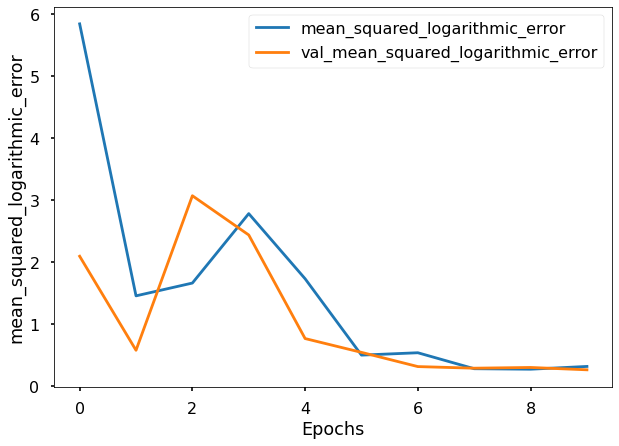

In [26]:
def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()
# Plot the history
plot_history(history, 'mean_squared_logarithmic_error')

                     GLOBALGOAL
date                           
2018-07-14 05:00:00   21.468704
2019-06-13 05:00:00    3.666167
2017-05-07 05:00:00   72.430771
2017-06-26 05:00:00   51.966780
2019-04-24 05:00:00   62.527985
...                         ...
2017-04-20 05:00:00   17.276443
2017-04-29 05:00:00    9.998032
2018-06-11 05:00:00   64.511967
2018-08-12 05:00:00   76.944754
2018-08-16 05:00:00   20.009317

[65 rows x 1 columns]
39.42040538543457


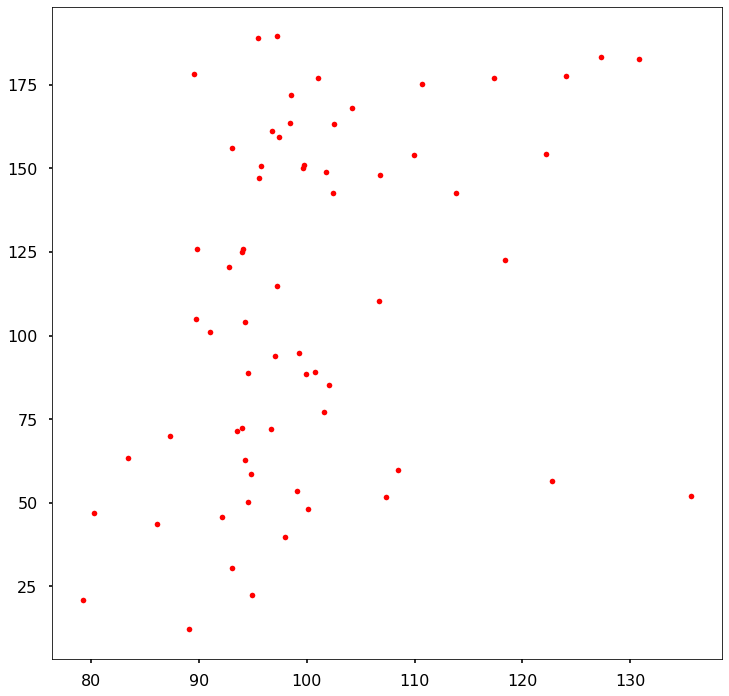

In [27]:
model5.predict(X_test5)
ax = plt.figure( figsize = (12,12) )
# plt.scatter(X_test,model.predict(X_test),color='blue',marker='.')
# plt.scatter(X_test,y_test,color='red',marker='.')
plt.plot(model5.predict(X_test5),y_test5,color='red',linestyle='none',marker='.')
lathos5 = np.abs((model5.predict(X_test5) - y_test5))#/y_test
print((lathos5))
print(100 * np.average(lathos5)/np.average(y_test5))
# plt.plot(data.index,y_test,linestyle='none',marker='.')

In [28]:
import sklearn
from sklearn.metrics import r2_score
sklearn.metrics.r2_score(model5.predict(X_test5), y_test5)

-17.634575695704196

In [29]:
abserr5 = np.abs((model5.predict(X_test5) - y_test5))#/y_test
# print((lathos))
print(abserr5)
# print(max(abserr))
relerr5 = (100 * np.average(abserr5)/np.average(y_test5))
relerr15 = 100 * np.average(abserr5/y_test5)
print('relerr5 =',relerr5)
print('relerr15 =',relerr15)

                     GLOBALGOAL
date                           
2018-07-14 05:00:00   21.468704
2019-06-13 05:00:00    3.666167
2017-05-07 05:00:00   72.430771
2017-06-26 05:00:00   51.966780
2019-04-24 05:00:00   62.527985
...                         ...
2017-04-20 05:00:00   17.276443
2017-04-29 05:00:00    9.998032
2018-06-11 05:00:00   64.511967
2018-08-12 05:00:00   76.944754
2018-08-16 05:00:00   20.009317

[65 rows x 1 columns]
relerr5 = 39.42040538543457
relerr15 = 62.133383928824784


# Hour 6

In [30]:
GLOBALGOAL6=[None]*len(new_data6prev);
for l in range (0, len(new_data6prev)):
    GLOBALGOAL6[l]=new_data6next.GLOBAL[l] 
print()

new_data6prev['GLOBALGOAL'] = GLOBALGOAL6
# new_data6prev

In [31]:
X6 = new_data6prev[["mT2","mRH","GLOBAL","SAA","SZA","DIRECT","DIFFUSE"]]
Y6 = new_data6prev[['GLOBALGOAL']]

In [32]:
from sklearn.model_selection import train_test_split
X_train6, X_test6, y_train6, y_test6 = train_test_split(X6, Y6, test_size=0.2, random_state=0)

In [33]:
hidden_units16 = 160
hidden_units26 = 480
hidden_units36 = 256
# hidden_units4 = 200
learning_rate6 = 0.01
# Creating model using the Sequential in tensorflow
def build_model_using_sequential():
  model6 = Sequential([
    Dense(hidden_units16, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units26, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units36, kernel_initializer='normal', activation='relu'),
#     Dropout(0.2),
#     Dense(hidden_units4, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')
  ])
  return model6
# build the model
model6 = build_model_using_sequential()

In [34]:
# loss function
msle = MeanSquaredLogarithmicError()

model6.compile(
    loss=msle, 
    optimizer=Adam(learning_rate=learning_rate6), 
    metrics=[msle]    
)
# train the model
history = model6.fit(
    X_train6, 
    y_train6, 
    epochs=10, 
    batch_size=64, #50
    validation_split=0.2
)

Epoch 1/10
6/6 [==============================] - 2s 108ms/step - loss: 5.5324 - mean_squared_logarithmic_error: 4.9862 - val_loss: 0.2978 - val_mean_squared_logarithmic_error: 0.3142
Epoch 2/10
6/6 [==============================] - 0s 21ms/step - loss: 0.5105 - mean_squared_logarithmic_error: 0.5425 - val_loss: 0.4943 - val_mean_squared_logarithmic_error: 0.4726
Epoch 3/10
6/6 [==============================] - 0s 20ms/step - loss: 0.3901 - mean_squared_logarithmic_error: 0.4003 - val_loss: 0.3711 - val_mean_squared_logarithmic_error: 0.4332
Epoch 4/10
6/6 [==============================] - 0s 23ms/step - loss: 0.3606 - mean_squared_logarithmic_error: 0.3519 - val_loss: 0.3347 - val_mean_squared_logarithmic_error: 0.3431
Epoch 5/10
6/6 [==============================] - 0s 36ms/step - loss: 0.3624 - mean_squared_logarithmic_error: 0.3514 - val_loss: 0.2630 - val_mean_squared_logarithmic_error: 0.2944
Epoch 6/10
6/6 [==============================] - 0s 37ms/step - loss: 0.3171 - mean

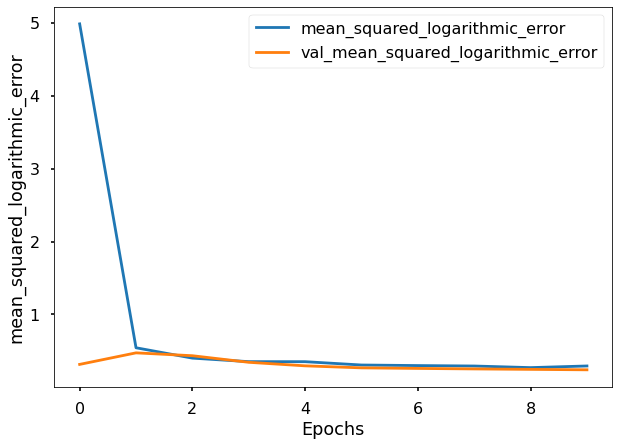

In [35]:
def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()
# Plot the history
plot_history(history, 'mean_squared_logarithmic_error')

                     GLOBALGOAL
date                           
2019-05-19 06:00:00  124.822580
2019-06-19 06:00:00   33.007462
2018-06-29 06:00:00  117.834579
2018-04-13 06:00:00   27.053043
2019-07-01 06:00:00  126.015405
...                         ...
2018-09-27 06:00:00   18.594814
2017-07-12 06:00:00   45.958380
2017-05-30 06:00:00  203.802742
2019-04-17 06:00:00   73.445190
2019-04-08 06:00:00   47.541666

[107 rows x 1 columns]
34.55417414537619


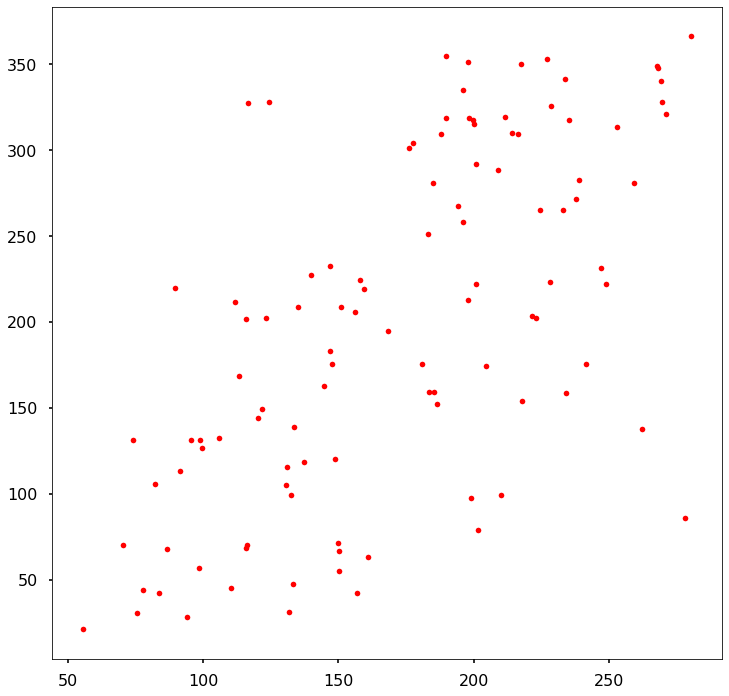

In [36]:
model6.predict(X_test6)
ax = plt.figure( figsize = (12,12) )

plt.plot(model6.predict(X_test6),y_test6,color='red',linestyle='none',marker='.')
lathos6 = np.abs((model6.predict(X_test6) - y_test6))#/y_test
print((lathos6))
print(100 * np.average(lathos6)/np.average(y_test6))

In [37]:
sklearn.metrics.r2_score(model6.predict(X_test6), y_test6)

-1.0643454901044285

In [38]:
abserr6 = np.abs((model6.predict(X_test6) - y_test6))#/y_test
print(abserr6)
relerr6 = (100 * np.average(abserr6)/np.average(y_test6))
relerr16 = 100 * np.average(abserr6/y_test6)
print('relerr6 =',relerr6)
print('relerr16 =',relerr16)

                     GLOBALGOAL
date                           
2019-05-19 06:00:00  124.822580
2019-06-19 06:00:00   33.007462
2018-06-29 06:00:00  117.834579
2018-04-13 06:00:00   27.053043
2019-07-01 06:00:00  126.015405
...                         ...
2018-09-27 06:00:00   18.594814
2017-07-12 06:00:00   45.958380
2017-05-30 06:00:00  203.802742
2019-04-17 06:00:00   73.445190
2019-04-08 06:00:00   47.541666

[107 rows x 1 columns]
relerr6 = 34.55417414537619
relerr16 = 50.26729798472333


# Hour 7

In [39]:
GLOBALGOAL7=[None]*len(new_data7prev);
for l in range (0, len(new_data7prev)):
    GLOBALGOAL7[l]=new_data7next.GLOBAL[l] 
print()

new_data7prev['GLOBALGOAL'] = GLOBALGOAL7
# new_data6prev

In [40]:
X7 = new_data7prev[["mT2","mRH","GLOBAL","SAA","SZA","DIRECT","DIFFUSE"]]
Y7 = new_data7prev[['GLOBALGOAL']]

In [41]:
from sklearn.model_selection import train_test_split
X_train7, X_test7, y_train7, y_test7 = train_test_split(X7, Y7, test_size=0.2, random_state=0)

In [42]:
hidden_units17 = 160
hidden_units27 = 480
hidden_units37 = 256
# hidden_units4 = 200
learning_rate7 = 0.01
# Creating model using the Sequential in tensorflow
def build_model_using_sequential():
  model7 = Sequential([
    Dense(hidden_units17, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units27, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units37, kernel_initializer='normal', activation='relu'),
#     Dropout(0.2),
#     Dense(hidden_units4, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')
  ])
  return model7
# build the model
model7 = build_model_using_sequential()

In [43]:
# loss function
msle = MeanSquaredLogarithmicError()

model7.compile(
    loss=msle, 
    optimizer=Adam(learning_rate=learning_rate7), 
    metrics=[msle]    
)
# train the model
history = model7.fit(
    X_train7, 
    y_train7, 
    epochs=10, 
    batch_size=64, #50
    validation_split=0.2
)

Epoch 1/10
8/8 [==============================] - 2s 78ms/step - loss: 5.9041 - mean_squared_logarithmic_error: 5.4655 - val_loss: 1.0172 - val_mean_squared_logarithmic_error: 1.0265
Epoch 2/10
8/8 [==============================] - 0s 16ms/step - loss: 4.0182 - mean_squared_logarithmic_error: 4.0945 - val_loss: 4.1698 - val_mean_squared_logarithmic_error: 4.1841
Epoch 3/10
8/8 [==============================] - 0s 19ms/step - loss: 2.7672 - mean_squared_logarithmic_error: 2.7230 - val_loss: 16.6143 - val_mean_squared_logarithmic_error: 16.6704
Epoch 4/10
8/8 [==============================] - 0s 15ms/step - loss: 4.6694 - mean_squared_logarithmic_error: 4.3840 - val_loss: 3.4583 - val_mean_squared_logarithmic_error: 3.4709
Epoch 5/10
8/8 [==============================] - 0s 15ms/step - loss: 3.0513 - mean_squared_logarithmic_error: 2.8350 - val_loss: 1.0513 - val_mean_squared_logarithmic_error: 1.0588
Epoch 6/10
8/8 [==============================] - 0s 15ms/step - loss: 0.9640 - mea

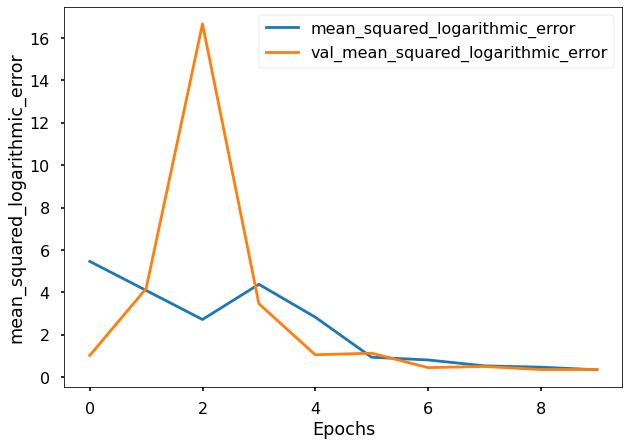

In [44]:
def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()
# Plot the history
plot_history(history, 'mean_squared_logarithmic_error')

40.18718197595185


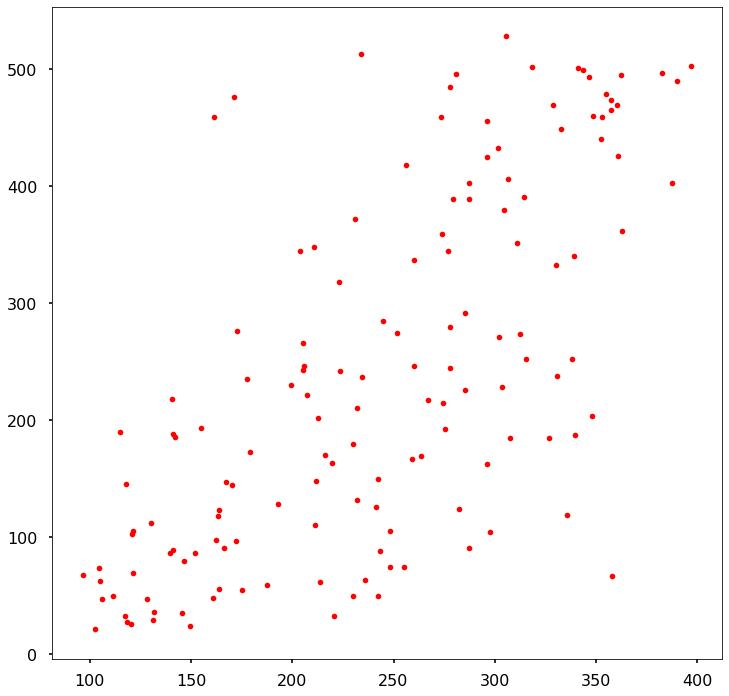

In [45]:
model7.predict(X_test7)
ax = plt.figure( figsize = (12,12) )

plt.plot(model7.predict(X_test7),y_test7,color='red',linestyle='none',marker='.')
lathos7 = np.abs((model7.predict(X_test7) - y_test7))#/y_test
# print((lathos7))
print(100 * np.average(lathos7)/np.average(y_test7))

In [46]:
sklearn.metrics.r2_score(model7.predict(X_test7), y_test7)

-1.0477011597019463

In [47]:
abserr7 = np.abs((model7.predict(X_test7) - y_test7))#/y_test
# print(abserr7)
relerr7 = (100 * np.average(abserr7)/np.average(y_test7))
relerr17 = 100 * np.average(abserr7/y_test7)
print('relerr7 =',relerr7)
print('relerr17 =',relerr17)

relerr7 = 40.18718197595185
relerr17 = 81.34127039851795


# Hour 8

In [48]:
GLOBALGOAL8=[None]*len(new_data8prev);
for l in range (0, len(new_data8prev)):
    GLOBALGOAL8[l]=new_data8next.GLOBAL[l] 
print()

new_data8prev['GLOBALGOAL'] = GLOBALGOAL8

In [49]:
X8 = new_data8prev[["mT2","mRH","GLOBAL","SAA","SZA","DIRECT","DIFFUSE"]]
Y8 = new_data8prev[['GLOBALGOAL']]
from sklearn.model_selection import train_test_split
X_train8, X_test8, y_train8, y_test8 = train_test_split(X8, Y8, test_size=0.2, random_state=0)

In [50]:
hidden_units18 = 160
hidden_units28 = 480
hidden_units38 = 256
# hidden_units4 = 200
learning_rate8 = 0.01
# Creating model using the Sequential in tensorflow
def build_model_using_sequential():
  model8 = Sequential([
    Dense(hidden_units18, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units28, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units38, kernel_initializer='normal', activation='relu'),
#     Dropout(0.2),
#     Dense(hidden_units4, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')
  ])
  return model8
# build the model
model8 = build_model_using_sequential()

In [51]:
# loss function
msle = MeanSquaredLogarithmicError()

model8.compile(
    loss=msle, 
    optimizer=Adam(learning_rate=learning_rate8), 
    metrics=[msle]    
)
# train the model
history = model8.fit(
    X_train8, 
    y_train8, 
    epochs=10, 
    batch_size=64, #50
    validation_split=0.2
)

Epoch 1/10
10/10 [==============================] - 2s 64ms/step - loss: 4.8195 - mean_squared_logarithmic_error: 4.6802 - val_loss: 0.5336 - val_mean_squared_logarithmic_error: 0.5085
Epoch 2/10
10/10 [==============================] - 0s 17ms/step - loss: 3.5531 - mean_squared_logarithmic_error: 3.6497 - val_loss: 5.2595 - val_mean_squared_logarithmic_error: 5.2113
Epoch 3/10
10/10 [==============================] - 0s 14ms/step - loss: 4.0895 - mean_squared_logarithmic_error: 4.0005 - val_loss: 0.8990 - val_mean_squared_logarithmic_error: 0.8580
Epoch 4/10
10/10 [==============================] - 0s 14ms/step - loss: 2.0061 - mean_squared_logarithmic_error: 2.0265 - val_loss: 2.6761 - val_mean_squared_logarithmic_error: 2.6360
Epoch 5/10
10/10 [==============================] - 0s 14ms/step - loss: 2.3423 - mean_squared_logarithmic_error: 2.3175 - val_loss: 1.0126 - val_mean_squared_logarithmic_error: 0.9790
Epoch 6/10
10/10 [==============================] - 0s 12ms/step - loss: 0.

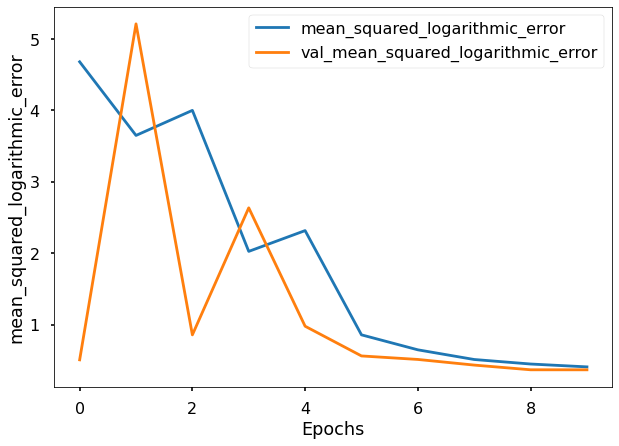

In [52]:
def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()
# Plot the history
plot_history(history, 'mean_squared_logarithmic_error')

In [53]:
sklearn.metrics.r2_score(model8.predict(X_test8), y_test8)

abserr8 = np.abs((model8.predict(X_test8) - y_test8))#/y_test
relerr8 = (100 * np.average(abserr8)/np.average(y_test8))
relerr18 = 100 * np.average(abserr8/y_test8)
print('relerr8 =',relerr8)
print('relerr18 =',relerr18)

relerr8 = 42.03968365348043
relerr18 = 68.60082525017779


# Hour 9

In [54]:
GLOBALGOAL9=[None]*len(new_data9prev);
for l in range (0, len(new_data9prev)):
    GLOBALGOAL9[l]=new_data9next.GLOBAL[l] 
print()

new_data9prev['GLOBALGOAL'] = GLOBALGOAL9

In [55]:
X9 = new_data9prev[["mT2","mRH","GLOBAL","SAA","SZA","DIRECT","DIFFUSE"]]
Y9 = new_data9prev[['GLOBALGOAL']]
from sklearn.model_selection import train_test_split
X_train9, X_test9, y_train9, y_test9 = train_test_split(X9, Y9, test_size=0.2, random_state=0)

In [56]:
hidden_units19 = 160
hidden_units29 = 480
hidden_units39 = 256
# hidden_units4 = 200
learning_rate9 = 0.01
# Creating model using the Sequential in tensorflow
def build_model_using_sequential():
  model9 = Sequential([
    Dense(hidden_units19, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units29, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units39, kernel_initializer='normal', activation='relu'),
#     Dropout(0.2),
#     Dense(hidden_units4, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')
  ])
  return model9
# build the model
model9 = build_model_using_sequential()

In [57]:
# loss function
msle = MeanSquaredLogarithmicError()

model9.compile(
    loss=msle, 
    optimizer=Adam(learning_rate=learning_rate9), 
    metrics=[msle]    
)
# train the model
history = model9.fit(
    X_train9, 
    y_train9, 
    epochs=10, 
    batch_size=64, #50
    validation_split=0.2
)

Epoch 1/10
11/11 [==============================] - 2s 61ms/step - loss: 4.7947 - mean_squared_logarithmic_error: 4.5523 - val_loss: 1.2953 - val_mean_squared_logarithmic_error: 1.2965
Epoch 2/10
11/11 [==============================] - 0s 13ms/step - loss: 2.8159 - mean_squared_logarithmic_error: 2.7476 - val_loss: 1.1651 - val_mean_squared_logarithmic_error: 1.1068
Epoch 3/10
11/11 [==============================] - 0s 12ms/step - loss: 1.1756 - mean_squared_logarithmic_error: 1.1559 - val_loss: 0.3797 - val_mean_squared_logarithmic_error: 0.3888
Epoch 4/10
11/11 [==============================] - 0s 14ms/step - loss: 0.8169 - mean_squared_logarithmic_error: 0.8149 - val_loss: 0.4215 - val_mean_squared_logarithmic_error: 0.4246
Epoch 5/10
11/11 [==============================] - 0s 15ms/step - loss: 0.5200 - mean_squared_logarithmic_error: 0.5007 - val_loss: 0.3875 - val_mean_squared_logarithmic_error: 0.3887
Epoch 6/10
11/11 [==============================] - 0s 14ms/step - loss: 0.

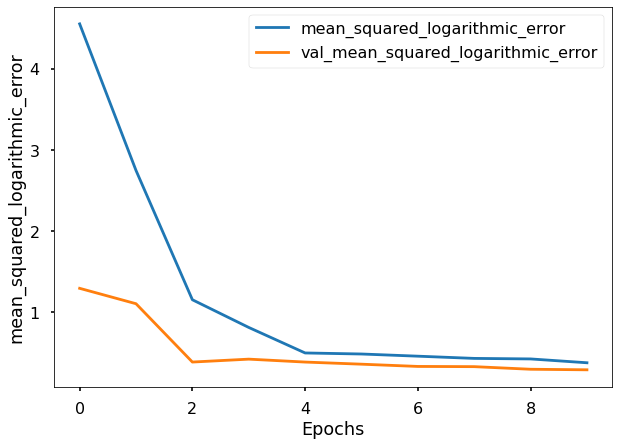

In [58]:
def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()
# Plot the history
plot_history(history, 'mean_squared_logarithmic_error')

In [59]:
sklearn.metrics.r2_score(model9.predict(X_test9), y_test9)

abserr9 = np.abs((model9.predict(X_test9) - y_test9))#/y_test
relerr9 = (100 * np.average(abserr9)/np.average(y_test9))
relerr19 = 100 * np.average(abserr9/y_test9)
print('relerr9 =',relerr9)
print('relerr19 =',relerr19)

relerr9 = 38.18989116943999
relerr19 = 54.91011346820187


# Hour 10

In [60]:
GLOBALGOAL10=[None]*len(new_data10prev);
for l in range (0, len(new_data10prev)):
    GLOBALGOAL10[l]=new_data10next.GLOBAL[l] 
print()

new_data10prev['GLOBALGOAL'] = GLOBALGOAL10

In [61]:
X10 = new_data10prev[["mT2","mRH","GLOBAL","SAA","SZA","DIRECT","DIFFUSE"]]
Y10 = new_data10prev[['GLOBALGOAL']]
from sklearn.model_selection import train_test_split
X_train10, X_test10, y_train10, y_test10 = train_test_split(X10, Y10, test_size=0.2, random_state=0)

In [62]:
hidden_units110 = 160
hidden_units210 = 480
hidden_units310 = 256
# hidden_units4 = 200
learning_rate10 = 0.01
# Creating model using the Sequential in tensorflow
def build_model_using_sequential():
  model10 = Sequential([
    Dense(hidden_units110, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units210, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units310, kernel_initializer='normal', activation='relu'),
#     Dropout(0.2),
#     Dense(hidden_units4, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')
  ])
  return model10
# build the model
model10 = build_model_using_sequential()

In [63]:
# loss function
msle = MeanSquaredLogarithmicError()

model10.compile(
    loss=msle, 
    optimizer=Adam(learning_rate=learning_rate10), 
    metrics=[msle]    
)
# train the model
history = model10.fit(
    X_train10, 
    y_train10, 
    epochs=10, 
    batch_size=64, #50
    validation_split=0.2
)

Epoch 1/10
11/11 [==============================] - 2s 60ms/step - loss: 4.8736 - mean_squared_logarithmic_error: 4.7130 - val_loss: 6.2526 - val_mean_squared_logarithmic_error: 6.1415
Epoch 2/10
11/11 [==============================] - 0s 16ms/step - loss: 1.3511 - mean_squared_logarithmic_error: 1.3323 - val_loss: 0.9876 - val_mean_squared_logarithmic_error: 0.9569
Epoch 3/10
11/11 [==============================] - 0s 14ms/step - loss: 0.6883 - mean_squared_logarithmic_error: 0.6805 - val_loss: 0.4941 - val_mean_squared_logarithmic_error: 0.4881
Epoch 4/10
11/11 [==============================] - 0s 14ms/step - loss: 0.4658 - mean_squared_logarithmic_error: 0.4705 - val_loss: 0.4732 - val_mean_squared_logarithmic_error: 0.4632
Epoch 5/10
11/11 [==============================] - 0s 19ms/step - loss: 0.4308 - mean_squared_logarithmic_error: 0.4314 - val_loss: 0.4658 - val_mean_squared_logarithmic_error: 0.4545
Epoch 6/10
11/11 [==============================] - 0s 18ms/step - loss: 0.

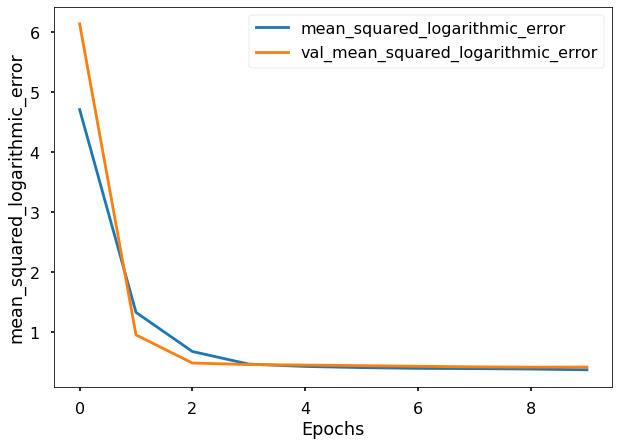

In [64]:
def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()
# Plot the history
plot_history(history, 'mean_squared_logarithmic_error')

In [65]:
sklearn.metrics.r2_score(model10.predict(X_test10), y_test10)

abserr10 = np.abs((model10.predict(X_test10) - y_test10))#/y_test
relerr10 = (100 * np.average(abserr10)/np.average(y_test10))
relerr110 = 100 * np.average(abserr10/y_test10)
print('relerr10 =',relerr10)
print('relerr110 =',relerr110)

relerr10 = 32.17457494685558
relerr110 = 61.00906391371667


# Hour 11

In [66]:
GLOBALGOAL11=[None]*len(new_data11prev);
for l in range (0, len(new_data11prev)):
    GLOBALGOAL11[l]=new_data11next.GLOBAL[l] 
print()

new_data11prev['GLOBALGOAL'] = GLOBALGOAL11

In [67]:
X11 = new_data11prev[["mT2","mRH","GLOBAL","SAA","SZA","DIRECT","DIFFUSE"]]
Y11 = new_data11prev[['GLOBALGOAL']]
from sklearn.model_selection import train_test_split
X_train11, X_test11, y_train11, y_test11 = train_test_split(X11, Y11, test_size=0.2, random_state=0)

In [68]:
hidden_units111 = 160
hidden_units211 = 480
hidden_units311 = 256
# hidden_units4 = 200
learning_rate11 = 0.01
# Creating model using the Sequential in tensorflow
def build_model_using_sequential():
  model11 = Sequential([
    Dense(hidden_units111, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units211, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units311, kernel_initializer='normal', activation='relu'),
#     Dropout(0.2),
#     Dense(hidden_units4, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')
  ])
  return model11
# build the model
model11 = build_model_using_sequential()

In [69]:
# loss function
msle = MeanSquaredLogarithmicError()

model11.compile(
    loss=msle, 
    optimizer=Adam(learning_rate=learning_rate11), 
    metrics=[msle]    
)
# train the model
history = model11.fit(
    X_train11, 
    y_train11, 
    epochs=10, 
    batch_size=64, #50
    validation_split=0.2
)

Epoch 1/10
11/11 [==============================] - 2s 59ms/step - loss: 5.5281 - mean_squared_logarithmic_error: 5.3802 - val_loss: 2.0186 - val_mean_squared_logarithmic_error: 2.0328
Epoch 2/10
11/11 [==============================] - 0s 13ms/step - loss: 2.7623 - mean_squared_logarithmic_error: 2.7046 - val_loss: 1.9960 - val_mean_squared_logarithmic_error: 1.9946
Epoch 3/10
11/11 [==============================] - 0s 14ms/step - loss: 1.3822 - mean_squared_logarithmic_error: 1.3622 - val_loss: 1.1083 - val_mean_squared_logarithmic_error: 1.1113
Epoch 4/10
11/11 [==============================] - 0s 13ms/step - loss: 0.6773 - mean_squared_logarithmic_error: 0.6692 - val_loss: 0.4712 - val_mean_squared_logarithmic_error: 0.4766
Epoch 5/10
11/11 [==============================] - 0s 12ms/step - loss: 0.4777 - mean_squared_logarithmic_error: 0.4754 - val_loss: 0.3958 - val_mean_squared_logarithmic_error: 0.4013
Epoch 6/10
11/11 [==============================] - 0s 14ms/step - loss: 0.

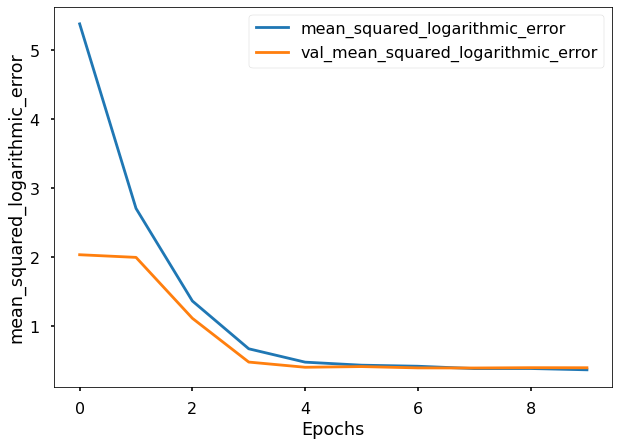

In [70]:
def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()
# Plot the history
plot_history(history, 'mean_squared_logarithmic_error')

In [71]:
sklearn.metrics.r2_score(model11.predict(X_test11), y_test11)

abserr11 = np.abs((model11.predict(X_test11) - y_test11))#/y_test
relerr11 = (100 * np.average(abserr11)/np.average(y_test11))
relerr111 = 100 * np.average(abserr11/y_test11)
print('relerr11 =',relerr11)
print('relerr111 =',relerr111)

relerr11 = 37.90686598779952
relerr111 = 62.743741158978395


# Hour 12

In [72]:
GLOBALGOAL12=[None]*len(new_data12prev);
for l in range (0, len(new_data12prev)):
    GLOBALGOAL12[l]=new_data12next.GLOBAL[l] 
print()

new_data12prev['GLOBALGOAL'] = GLOBALGOAL12

In [73]:
X12 = new_data12prev[["mT2","mRH","GLOBAL","SAA","SZA","DIRECT","DIFFUSE"]]
Y12 = new_data12prev[['GLOBALGOAL']]
from sklearn.model_selection import train_test_split
X_train12, X_test12, y_train12, y_test12 = train_test_split(X12, Y12, test_size=0.2, random_state=0)

In [74]:
hidden_units112 = 160
hidden_units212 = 480
hidden_units312 = 256
# hidden_units4 = 200
learning_rate12 = 0.01
# Creating model using the Sequential in tensorflow
def build_model_using_sequential():
  model12 = Sequential([
    Dense(hidden_units112, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units212, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units312, kernel_initializer='normal', activation='relu'),
#     Dropout(0.2),
#     Dense(hidden_units4, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')
  ])
  return model12
# build the model
model12 = build_model_using_sequential()

In [75]:
# loss function
msle = MeanSquaredLogarithmicError()

model12.compile(
    loss=msle, 
    optimizer=Adam(learning_rate=learning_rate12), 
    metrics=[msle]    
)
# train the model
history = model12.fit(
    X_train12, 
    y_train12, 
    epochs=10, 
    batch_size=64, #50
    validation_split=0.2
)

Epoch 1/10
11/11 [==============================] - 2s 55ms/step - loss: 5.2389 - mean_squared_logarithmic_error: 5.1661 - val_loss: 1.7792 - val_mean_squared_logarithmic_error: 1.8348
Epoch 2/10
11/11 [==============================] - 0s 14ms/step - loss: 1.2129 - mean_squared_logarithmic_error: 1.2071 - val_loss: 0.6315 - val_mean_squared_logarithmic_error: 0.6541
Epoch 3/10
11/11 [==============================] - 0s 14ms/step - loss: 0.8711 - mean_squared_logarithmic_error: 0.9079 - val_loss: 2.1359 - val_mean_squared_logarithmic_error: 2.1925
Epoch 4/10
11/11 [==============================] - 0s 15ms/step - loss: 2.1061 - mean_squared_logarithmic_error: 2.0786 - val_loss: 1.1395 - val_mean_squared_logarithmic_error: 1.1790
Epoch 5/10
11/11 [==============================] - 0s 14ms/step - loss: 0.9417 - mean_squared_logarithmic_error: 0.9289 - val_loss: 0.6144 - val_mean_squared_logarithmic_error: 0.6125
Epoch 6/10
11/11 [==============================] - 0s 15ms/step - loss: 0.

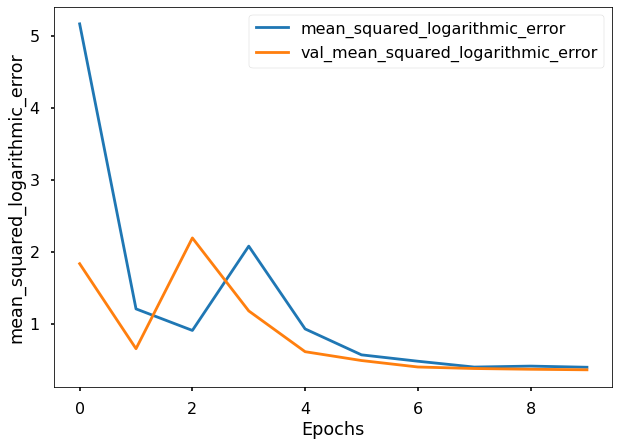

In [76]:
def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()
# Plot the history
plot_history(history, 'mean_squared_logarithmic_error')

In [77]:
sklearn.metrics.r2_score(model12.predict(X_test12), y_test12)

abserr12 = np.abs((model12.predict(X_test12) - y_test12))#/y_test
relerr12 = (100 * np.average(abserr12)/np.average(y_test12))
relerr112 = 100 * np.average(abserr12/y_test12)
print('relerr12 =',relerr12)
print('relerr112 =',relerr112)

relerr12 = 38.9062159630072
relerr112 = 63.577352262519184


# Hour 13

In [78]:
GLOBALGOAL13=[None]*len(new_data13prev);
for l in range (0, len(new_data13prev)):
    GLOBALGOAL13[l]=new_data13next.GLOBAL[l] 
print()

new_data13prev['GLOBALGOAL'] = GLOBALGOAL13

In [79]:
X13 = new_data13prev[["mT2","mRH","GLOBAL","SAA","SZA","DIRECT","DIFFUSE"]]
Y13 = new_data13prev[['GLOBALGOAL']]
from sklearn.model_selection import train_test_split
X_train13, X_test13, y_train13, y_test13 = train_test_split(X13, Y13, test_size=0.2, random_state=0)

In [80]:
hidden_units113 = 160
hidden_units213 = 480
hidden_units313 = 256
# hidden_units4 = 200
learning_rate13 = 0.01
# Creating model using the Sequential in tensorflow
def build_model_using_sequential():
  model13 = Sequential([
    Dense(hidden_units113, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units213, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units313, kernel_initializer='normal', activation='relu'),
#     Dropout(0.2),
#     Dense(hidden_units4, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')
  ])
  return model13
# build the model
model13 = build_model_using_sequential()

In [81]:
# loss function
msle = MeanSquaredLogarithmicError()

model13.compile(
    loss=msle, 
    optimizer=Adam(learning_rate=learning_rate13), 
    metrics=[msle]    
)
# train the model
history = model13.fit(
    X_train13, 
    y_train13, 
    epochs=10, 
    batch_size=64, #50
    validation_split=0.2
)

Epoch 1/10
11/11 [==============================] - 2s 56ms/step - loss: 4.9930 - mean_squared_logarithmic_error: 4.7976 - val_loss: 5.5566 - val_mean_squared_logarithmic_error: 5.7551
Epoch 2/10
11/11 [==============================] - 0s 12ms/step - loss: 2.3253 - mean_squared_logarithmic_error: 2.2484 - val_loss: 0.7298 - val_mean_squared_logarithmic_error: 0.7108
Epoch 3/10
11/11 [==============================] - 0s 13ms/step - loss: 0.9972 - mean_squared_logarithmic_error: 0.9466 - val_loss: 0.5389 - val_mean_squared_logarithmic_error: 0.5365
Epoch 4/10
11/11 [==============================] - 0s 13ms/step - loss: 0.5086 - mean_squared_logarithmic_error: 0.4998 - val_loss: 0.5119 - val_mean_squared_logarithmic_error: 0.4930
Epoch 5/10
11/11 [==============================] - 0s 12ms/step - loss: 0.4102 - mean_squared_logarithmic_error: 0.3924 - val_loss: 0.4428 - val_mean_squared_logarithmic_error: 0.4347
Epoch 6/10
11/11 [==============================] - 0s 12ms/step - loss: 0.

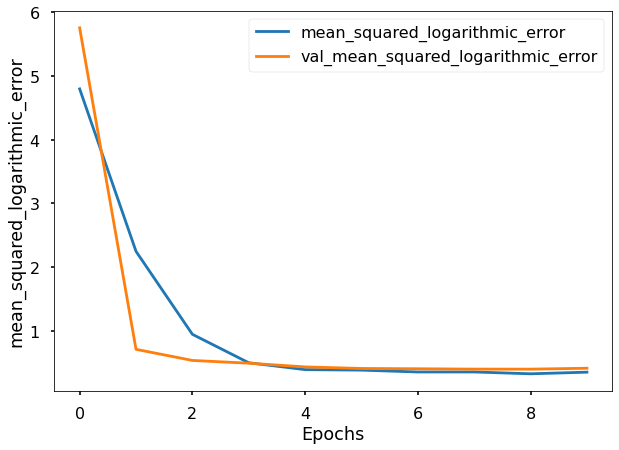

In [82]:
def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()
# Plot the history
plot_history(history, 'mean_squared_logarithmic_error')

In [83]:
sklearn.metrics.r2_score(model13.predict(X_test13), y_test13)

abserr13 = np.abs((model13.predict(X_test13) - y_test13))#/y_test
relerr13 = (100 * np.average(abserr13)/np.average(y_test13))
relerr113 = 100 * np.average(abserr13/y_test13)
print('relerr13 =',relerr13)
print('relerr113 =',relerr113)

relerr13 = 39.62362429892049
relerr113 = 54.89278967232575


# Hour 14

In [84]:
GLOBALGOAL14=[None]*len(new_data14prev);
for l in range (0, len(new_data14prev)):
    GLOBALGOAL14[l]=new_data14next.GLOBAL[l] 
print()

new_data14prev['GLOBALGOAL'] = GLOBALGOAL14

In [85]:
X14 = new_data14prev[["mT2","mRH","GLOBAL","SAA","SZA","DIRECT","DIFFUSE"]]
Y14 = new_data14prev[['GLOBALGOAL']]
from sklearn.model_selection import train_test_split
X_train14, X_test14, y_train14, y_test14 = train_test_split(X14, Y14, test_size=0.2, random_state=0)

In [86]:
hidden_units114 = 160
hidden_units214 = 480
hidden_units314 = 256
# hidden_units4 = 200
learning_rate14 = 0.01
# Creating model using the Sequential in tensorflow
def build_model_using_sequential():
  model14 = Sequential([
    Dense(hidden_units114, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units214, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units314, kernel_initializer='normal', activation='relu'),
#     Dropout(0.2),
#     Dense(hidden_units4, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')
  ])
  return model14
# build the model
model14 = build_model_using_sequential()

In [87]:
# loss function
msle = MeanSquaredLogarithmicError()

model14.compile(
    loss=msle, 
    optimizer=Adam(learning_rate=learning_rate14), 
    metrics=[msle]    
)
# train the model
history = model14.fit(
    X_train14, 
    y_train14, 
    epochs=10, 
    batch_size=64, #50
    validation_split=0.2
)

Epoch 1/10
10/10 [==============================] - 2s 63ms/step - loss: 5.2676 - mean_squared_logarithmic_error: 5.1972 - val_loss: 1.9142 - val_mean_squared_logarithmic_error: 1.8635
Epoch 2/10
10/10 [==============================] - 0s 15ms/step - loss: 2.0526 - mean_squared_logarithmic_error: 2.1855 - val_loss: 1.1254 - val_mean_squared_logarithmic_error: 1.0862
Epoch 3/10
10/10 [==============================] - 0s 15ms/step - loss: 3.8886 - mean_squared_logarithmic_error: 3.9066 - val_loss: 5.1046 - val_mean_squared_logarithmic_error: 5.0731
Epoch 4/10
10/10 [==============================] - 0s 17ms/step - loss: 3.2424 - mean_squared_logarithmic_error: 3.1977 - val_loss: 0.6569 - val_mean_squared_logarithmic_error: 0.6236
Epoch 5/10
10/10 [==============================] - 0s 16ms/step - loss: 2.1836 - mean_squared_logarithmic_error: 2.1988 - val_loss: 3.1801 - val_mean_squared_logarithmic_error: 3.1520
Epoch 6/10
10/10 [==============================] - 0s 20ms/step - loss: 2.

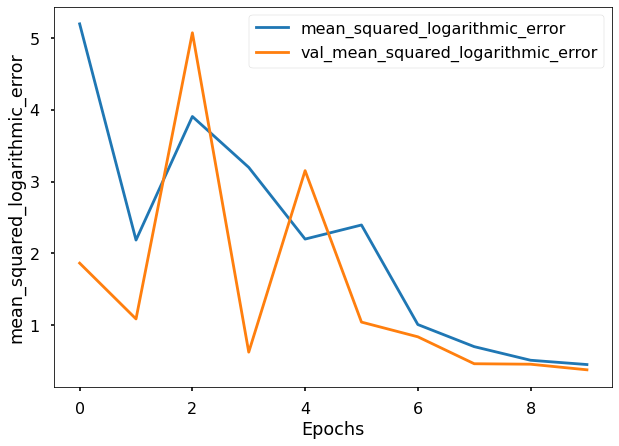

In [88]:
def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()
# Plot the history
plot_history(history, 'mean_squared_logarithmic_error')

In [89]:
sklearn.metrics.r2_score(model14.predict(X_test14), y_test14)

abserr14 = np.abs((model14.predict(X_test14) - y_test14))#/y_test
relerr14 = (100 * np.average(abserr14)/np.average(y_test14))
relerr114 = 100 * np.average(abserr14/y_test14)
print('relerr14 =',relerr14)
print('relerr114 =',relerr114)

relerr14 = 38.90419644942705
relerr114 = 56.35060816259918


# Hour 15

In [90]:
GLOBALGOAL15=[None]*len(new_data15prev);
for l in range (0, len(new_data15prev)):
    GLOBALGOAL15[l]=new_data15next.GLOBAL[l] 
print()

new_data15prev['GLOBALGOAL'] = GLOBALGOAL15

In [91]:
X15 = new_data15prev[["mT2","mRH","GLOBAL","SAA","SZA","DIRECT","DIFFUSE"]]
Y15 = new_data15prev[['GLOBALGOAL']]
from sklearn.model_selection import train_test_split
X_train15, X_test15, y_train15, y_test15 = train_test_split(X15, Y15, test_size=0.2, random_state=0)

In [92]:
hidden_units115 = 160
hidden_units215 = 480
hidden_units315 = 256
# hidden_units4 = 200
learning_rate15 = 0.01
# Creating model using the Sequential in tensorflow
def build_model_using_sequential():
  model15 = Sequential([
    Dense(hidden_units115, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units215, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units315, kernel_initializer='normal', activation='relu'),
#     Dropout(0.2),
#     Dense(hidden_units4, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')
  ])
  return model15
# build the model
model15 = build_model_using_sequential()

In [93]:
# loss function
msle = MeanSquaredLogarithmicError()

model15.compile(
    loss=msle, 
    optimizer=Adam(learning_rate=learning_rate15), 
    metrics=[msle]    
)
# train the model
history = model15.fit(
    X_train15, 
    y_train15, 
    epochs=10, 
    batch_size=64, #50
    validation_split=0.2
)

Epoch 1/10
9/9 [==============================] - 2s 62ms/step - loss: 5.1626 - mean_squared_logarithmic_error: 4.7345 - val_loss: 3.4776 - val_mean_squared_logarithmic_error: 2.8992
Epoch 2/10
9/9 [==============================] - 0s 13ms/step - loss: 2.1658 - mean_squared_logarithmic_error: 2.0729 - val_loss: 1.0896 - val_mean_squared_logarithmic_error: 1.2491
Epoch 3/10
9/9 [==============================] - 0s 13ms/step - loss: 0.7266 - mean_squared_logarithmic_error: 0.7131 - val_loss: 0.4988 - val_mean_squared_logarithmic_error: 0.5929
Epoch 4/10
9/9 [==============================] - 0s 12ms/step - loss: 0.4193 - mean_squared_logarithmic_error: 0.4287 - val_loss: 0.3135 - val_mean_squared_logarithmic_error: 0.3216
Epoch 5/10
9/9 [==============================] - 0s 14ms/step - loss: 0.3705 - mean_squared_logarithmic_error: 0.3569 - val_loss: 0.3300 - val_mean_squared_logarithmic_error: 0.3641
Epoch 6/10
9/9 [==============================] - 0s 14ms/step - loss: 0.3121 - mean_

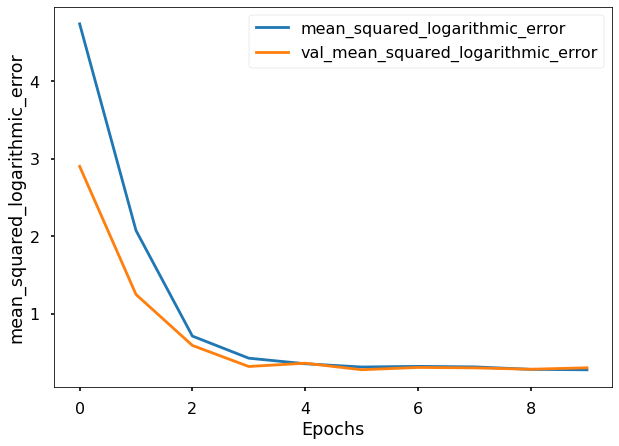

In [94]:
def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()
# Plot the history
plot_history(history, 'mean_squared_logarithmic_error')

In [95]:
sklearn.metrics.r2_score(model15.predict(X_test15), y_test15)

abserr15 = np.abs((model15.predict(X_test15) - y_test15))#/y_test
relerr15 = (100 * np.average(abserr15)/np.average(y_test15))
relerr115 = 100 * np.average(abserr15/y_test15)
print('relerr15 =',relerr15)
print('relerr115 =',relerr115)

relerr15 = 33.23016889559032
relerr115 = 47.51968394313405


# Hour 16

In [96]:
GLOBALGOAL16=[None]*len(new_data16prev);
for l in range (0, len(new_data16prev)):
    GLOBALGOAL16[l]=new_data16next.GLOBAL[l] 
print()

new_data16prev['GLOBALGOAL'] = GLOBALGOAL16

In [97]:
X16 = new_data16prev[["mT2","mRH","GLOBAL","SAA","SZA","DIRECT","DIFFUSE"]]
Y16 = new_data16prev[['GLOBALGOAL']]
from sklearn.model_selection import train_test_split
X_train16, X_test16, y_train16, y_test16 = train_test_split(X16, Y16, test_size=0.2, random_state=0)

In [98]:
hidden_units116 = 160
hidden_units216 = 480
hidden_units316 = 256
# hidden_units4 = 200
learning_rate16 = 0.01
# Creating model using the Sequential in tensorflow
def build_model_using_sequential():
  model16 = Sequential([
    Dense(hidden_units116, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units216, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units316, kernel_initializer='normal', activation='relu'),
#     Dropout(0.2),
#     Dense(hidden_units4, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')
  ])
  return model16
# build the model
model16 = build_model_using_sequential()

In [99]:
# loss function
msle = MeanSquaredLogarithmicError()

model16.compile(
    loss=msle, 
    optimizer=Adam(learning_rate=learning_rate16), 
    metrics=[msle]    
)
# train the model
history = model16.fit(
    X_train16, 
    y_train16, 
    epochs=10, 
    batch_size=64, #50
    validation_split=0.2
)

Epoch 1/10
7/7 [==============================] - 2s 84ms/step - loss: 5.4726 - mean_squared_logarithmic_error: 5.4175 - val_loss: 4.4789 - val_mean_squared_logarithmic_error: 4.3936
Epoch 2/10
7/7 [==============================] - 0s 20ms/step - loss: 2.3573 - mean_squared_logarithmic_error: 2.2182 - val_loss: 0.9063 - val_mean_squared_logarithmic_error: 0.8629
Epoch 3/10
7/7 [==============================] - 0s 19ms/step - loss: 0.8999 - mean_squared_logarithmic_error: 0.9095 - val_loss: 0.3584 - val_mean_squared_logarithmic_error: 0.3398
Epoch 4/10
7/7 [==============================] - 0s 17ms/step - loss: 0.3708 - mean_squared_logarithmic_error: 0.3504 - val_loss: 0.3038 - val_mean_squared_logarithmic_error: 0.2859
Epoch 5/10
7/7 [==============================] - 0s 18ms/step - loss: 0.3521 - mean_squared_logarithmic_error: 0.3498 - val_loss: 0.3500 - val_mean_squared_logarithmic_error: 0.3237
Epoch 6/10
7/7 [==============================] - 0s 21ms/step - loss: 0.3131 - mean_

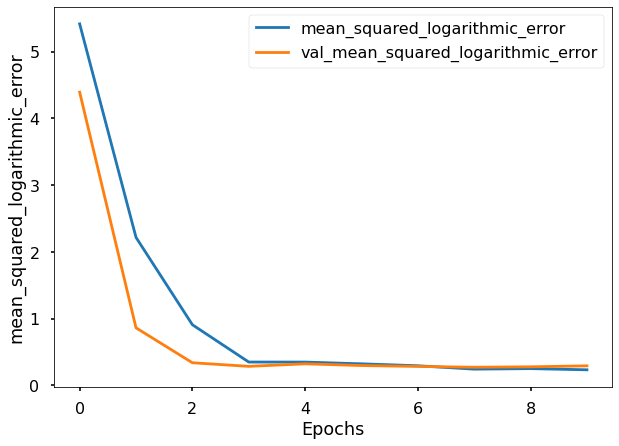

In [100]:
def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()
# Plot the history
plot_history(history, 'mean_squared_logarithmic_error')

In [101]:
sklearn.metrics.r2_score(model16.predict(X_test16), y_test16)

abserr16 = np.abs((model16.predict(X_test16) - y_test16))#/y_test
relerr16 = (100 * np.average(abserr16)/np.average(y_test16))
relerr116 = 100 * np.average(abserr16/y_test16)
print('relerr16 =',relerr16)
print('relerr116 =',relerr116)

relerr16 = 33.31782741261186
relerr116 = 46.01730620157359


# Hour 17

In [102]:
GLOBALGOAL17=[None]*len(new_data17prev);
for l in range (0, len(new_data17prev)):
    GLOBALGOAL17[l]=new_data17next.GLOBAL[l] 
print()

new_data17prev['GLOBALGOAL'] = GLOBALGOAL17

In [103]:
X17 = new_data17prev[["mT2","mRH","GLOBAL","SAA","SZA","DIRECT","DIFFUSE"]]
Y17 = new_data17prev[['GLOBALGOAL']]
from sklearn.model_selection import train_test_split
X_train17, X_test17, y_train17, y_test17 = train_test_split(X17, Y17, test_size=0.2, random_state=0)

In [104]:
hidden_units117 = 160
hidden_units217 = 480
hidden_units317 = 256
# hidden_units4 = 200
learning_rate17 = 0.01
# Creating model using the Sequential in tensorflow
def build_model_using_sequential():
  model17 = Sequential([
    Dense(hidden_units117, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units217, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units317, kernel_initializer='normal', activation='relu'),
#     Dropout(0.2),
#     Dense(hidden_units4, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')
  ])
  return model17
# build the model
model17 = build_model_using_sequential()

In [105]:
# loss function
msle = MeanSquaredLogarithmicError()

model17.compile(
    loss=msle, 
    optimizer=Adam(learning_rate=learning_rate17), 
    metrics=[msle]    
)
# train the model
history = model17.fit(
    X_train17, 
    y_train17, 
    epochs=10, 
    batch_size=64, #50
    validation_split=0.2
)

Epoch 1/10
5/5 [==============================] - 2s 138ms/step - loss: 5.9868 - mean_squared_logarithmic_error: 5.6603 - val_loss: 0.8710 - val_mean_squared_logarithmic_error: 0.7726
Epoch 2/10
5/5 [==============================] - 0s 25ms/step - loss: 0.9380 - mean_squared_logarithmic_error: 0.9383 - val_loss: 0.5889 - val_mean_squared_logarithmic_error: 0.4957
Epoch 3/10
5/5 [==============================] - 0s 23ms/step - loss: 0.6000 - mean_squared_logarithmic_error: 0.5830 - val_loss: 0.2884 - val_mean_squared_logarithmic_error: 0.2356
Epoch 4/10
5/5 [==============================] - 0s 25ms/step - loss: 0.3672 - mean_squared_logarithmic_error: 0.3613 - val_loss: 0.1787 - val_mean_squared_logarithmic_error: 0.2149
Epoch 5/10
5/5 [==============================] - 0s 27ms/step - loss: 0.2862 - mean_squared_logarithmic_error: 0.2857 - val_loss: 0.1510 - val_mean_squared_logarithmic_error: 0.1457
Epoch 6/10
5/5 [==============================] - 0s 37ms/step - loss: 0.2562 - mean

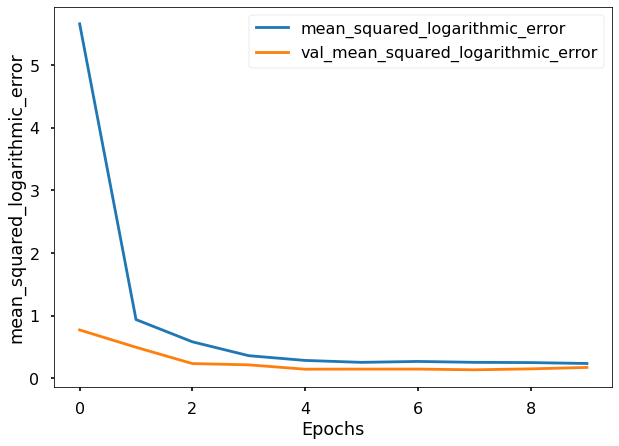

In [106]:
def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()
# Plot the history
plot_history(history, 'mean_squared_logarithmic_error')

In [107]:
sklearn.metrics.r2_score(model17.predict(X_test17), y_test17)

abserr17 = np.abs((model17.predict(X_test17) - y_test17))#/y_test
relerr17 = (100 * np.average(abserr17)/np.average(y_test17))
relerr117 = 100 * np.average(abserr17/y_test17)
print('relerr17 =',relerr17)
print('relerr117 =',relerr117)

relerr17 = 28.817941468721873
relerr117 = 31.79381713117635


# Hour 18

In [108]:
GLOBALGOAL18=[None]*len(new_data18prev);
for l in range (0, len(new_data18prev)):
    GLOBALGOAL18[l]=new_data18next.GLOBAL[l] 
print()

new_data18prev['GLOBALGOAL'] = GLOBALGOAL18

In [109]:
X18 = new_data18prev[["mT2","mRH","GLOBAL","SAA","SZA","DIRECT","DIFFUSE"]]
Y18 = new_data18prev[['GLOBALGOAL']]
from sklearn.model_selection import train_test_split
X_train18, X_test18, y_train18, y_test18 = train_test_split(X18, Y18, test_size=0.2, random_state=0)

In [110]:
hidden_units118 = 160
hidden_units218 = 480
hidden_units318 = 256
# hidden_units4 = 200
learning_rate18 = 0.01
# Creating model using the Sequential in tensorflow
def build_model_using_sequential():
  model18 = Sequential([
    Dense(hidden_units118, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units218, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units318, kernel_initializer='normal', activation='relu'),
#     Dropout(0.2),
#     Dense(hidden_units4, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')
  ])
  return model18
# build the model
model18 = build_model_using_sequential()

In [111]:
# loss function
msle = MeanSquaredLogarithmicError()

model18.compile(
    loss=msle, 
    optimizer=Adam(learning_rate=learning_rate18), 
    metrics=[msle]    
)
# train the model
history = model18.fit(
    X_train18, 
    y_train18, 
    epochs=10, 
    batch_size=64, #50
    validation_split=0.2
)

Epoch 1/10
3/3 [==============================] - 2s 228ms/step - loss: 7.8914 - mean_squared_logarithmic_error: 7.0555 - val_loss: 3.5757 - val_mean_squared_logarithmic_error: 3.5757
Epoch 2/10
3/3 [==============================] - 0s 30ms/step - loss: 3.0107 - mean_squared_logarithmic_error: 2.9306 - val_loss: 2.1690 - val_mean_squared_logarithmic_error: 2.1690
Epoch 3/10
3/3 [==============================] - 0s 32ms/step - loss: 4.5125 - mean_squared_logarithmic_error: 6.2975 - val_loss: 0.2928 - val_mean_squared_logarithmic_error: 0.2928
Epoch 4/10
3/3 [==============================] - 0s 41ms/step - loss: 1.3178 - mean_squared_logarithmic_error: 1.4487 - val_loss: 3.8217 - val_mean_squared_logarithmic_error: 3.8217
Epoch 5/10
3/3 [==============================] - 0s 33ms/step - loss: 3.3807 - mean_squared_logarithmic_error: 3.4097 - val_loss: 4.6001 - val_mean_squared_logarithmic_error: 4.6001
Epoch 6/10
3/3 [==============================] - 0s 29ms/step - loss: 3.7078 - mean

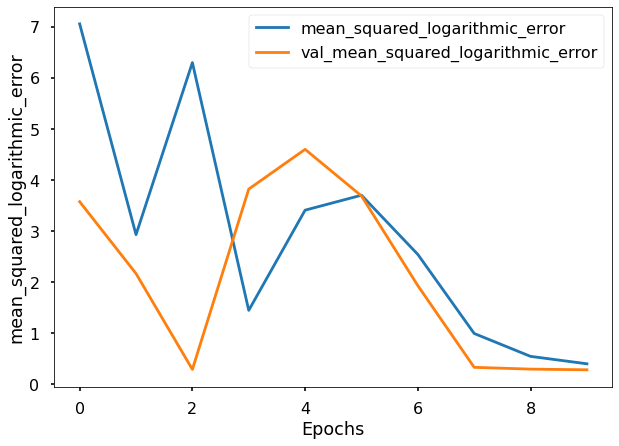

In [112]:
def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()
# Plot the history
plot_history(history, 'mean_squared_logarithmic_error')

In [113]:
sklearn.metrics.r2_score(model18.predict(X_test18), y_test18)

abserr18 = np.abs((model18.predict(X_test18) - y_test18))#/y_test
relerr18 = (100 * np.average(abserr18)/np.average(y_test18))
relerr118 = 100 * np.average(abserr18/y_test18)
print('relerr18 =',relerr18)
print('relerr118 =',relerr118)

relerr18 = 29.513072575498907
relerr118 = 34.823509238404135


In [114]:
datans5 = datans.loc[datans.index.hour == 5]
Xns5 = datans5[["mT2","mRH","GLOBAL","SAA","SZA","DIRECT","DIFFUSE"]]
model5.predict(Xns5)

abserrns5=[None] * (len(datans5)-1);
for l in range (0, len(datans5)-1):
    abserrns5[l] = np.abs(datans5.GLOBAL[l+1]-model5.predict(Xns5)[l]) 
print()
relerrns5 = 100 * np.average(abserrns5) / np.average(datans.GLOBAL)
print('relerrns5 =', relerrns5)

######################################################################

datans6 = datans.loc[datans.index.hour == 6]
Xns6 = datans6[["mT2","mRH","GLOBAL","SAA","SZA","DIRECT","DIFFUSE"]]
model6.predict(Xns6)

abserrns6=[None] * (len(datans6)-1);
for l in range (0, len(datans6)-1):
    abserrns6[l] = np.abs(datans6.GLOBAL[l+1]-model6.predict(Xns6)[l]) 
print()
relerrns6 = 100 * np.average(abserrns6) / np.average(datans.GLOBAL)
print('relerrns6 =', relerrns6)

######################################################################

datans7 = datans.loc[datans.index.hour == 7]
Xns7 = datans7[["mT2","mRH","GLOBAL","SAA","SZA","DIRECT","DIFFUSE"]]
model7.predict(Xns7)

abserrns7=[None] * (len(datans7)-1);
for l in range (0, len(datans7)-1):
    abserrns7[l] = np.abs(datans7.GLOBAL[l+1]-model7.predict(Xns7)[l]) 
print()
relerrns7 = 100 * np.average(abserrns7) / np.average(datans.GLOBAL)
print('relerrns7 =', relerrns7)

######################################################################

datans8 = datans.loc[datans.index.hour == 8]
Xns8 = datans8[["mT2","mRH","GLOBAL","SAA","SZA","DIRECT","DIFFUSE"]]
model8.predict(Xns8)

abserrns8=[None] * (len(datans8)-1);
for l in range (0, len(datans8)-1):
    abserrns8[l] = np.abs(datans8.GLOBAL[l+1]-model8.predict(Xns8)[l]) 
print()
relerrns8 = 100 * np.average(abserrns8) / np.average(datans.GLOBAL)
print('relerrns8 =', relerrns8)

######################################################################

datans9 = datans.loc[datans.index.hour == 9]
Xns9 = datans9[["mT2","mRH","GLOBAL","SAA","SZA","DIRECT","DIFFUSE"]]
model9.predict(Xns9)

abserrns9=[None] * (len(datans9)-1);
for l in range (0, len(datans9)-1):
    abserrns9[l] = np.abs(datans9.GLOBAL[l+1]-model9.predict(Xns9)[l]) 
print()
relerrns9 = 100 * np.average(abserrns9) / np.average(datans.GLOBAL)
print('relerrns9 =', relerrns9)

######################################################################

datans10 = datans.loc[datans.index.hour == 10]
Xns10 = datans10[["mT2","mRH","GLOBAL","SAA","SZA","DIRECT","DIFFUSE"]]
model10.predict(Xns10)

abserrns10=[None] * (len(datans10)-1);
for l in range (0, len(datans10)-1):
    abserrns10[l] = np.abs(datans10.GLOBAL[l+1]-model10.predict(Xns10)[l]) 
print()
relerrns10 = 100 * np.average(abserrns10) / np.average(datans.GLOBAL)
print('relerrns10 =', relerrns10)

######################################################################

datans11 = datans.loc[datans.index.hour == 11]
Xns11 = datans11[["mT2","mRH","GLOBAL","SAA","SZA","DIRECT","DIFFUSE"]]
model11.predict(Xns11)

abserrns11=[None] * (len(datans11)-1);
for l in range (0, len(datans11)-1):
    abserrns11[l] = np.abs(datans11.GLOBAL[l+1]-model11.predict(Xns11)[l]) 
print()
relerrns11 = 100 * np.average(abserrns11) / np.average(datans.GLOBAL)
print('relerrns11 =', relerrns11)

######################################################################

datans12 = datans.loc[datans.index.hour == 12]
Xns12 = datans12[["mT2","mRH","GLOBAL","SAA","SZA","DIRECT","DIFFUSE"]]
model12.predict(Xns12)

abserrns12=[None] * (len(datans12)-1);
for l in range (0, len(datans12)-1):
    abserrns12[l] = np.abs(datans12.GLOBAL[l+1]-model12.predict(Xns12)[l]) 
print()
relerrns12 = 100 * np.average(abserrns12) / np.average(datans.GLOBAL)
print('relerrns12 =', relerrns12)

######################################################################

datans13 = datans.loc[datans.index.hour == 13]
Xns13 = datans13[["mT2","mRH","GLOBAL","SAA","SZA","DIRECT","DIFFUSE"]]
model13.predict(Xns13)

abserrns13=[None] * (len(datans13)-1);
for l in range (0, len(datans13)-1):
    abserrns13[l] = np.abs(datans13.GLOBAL[l+1]-model13.predict(Xns13)[l]) 
print()
relerrns13 = 100 * np.average(abserrns13) / np.average(datans.GLOBAL)
print('relerrns13 =', relerrns13)

######################################################################

datans14 = datans.loc[datans.index.hour == 14]
Xns14 = datans14[["mT2","mRH","GLOBAL","SAA","SZA","DIRECT","DIFFUSE"]]
model14.predict(Xns14)

abserrns14=[None] * (len(datans14)-1);
for l in range (0, len(datans14)-1):
    abserrns14[l] = np.abs(datans14.GLOBAL[l+1]-model14.predict(Xns14)[l]) 
print()
relerrns14 = 100 * np.average(abserrns14) / np.average(datans.GLOBAL)
print('relerrns14 =', relerrns14)

######################################################################

datans15 = datans.loc[datans.index.hour == 15]
Xns15 = datans15[["mT2","mRH","GLOBAL","SAA","SZA","DIRECT","DIFFUSE"]]
model15.predict(Xns15)

abserrns15=[None] * (len(datans15)-1);
for l in range (0, len(datans15)-1):
    abserrns15[l] = np.abs(datans15.GLOBAL[l+1]-model15.predict(Xns15)[l]) 
print()
relerrns15 = 100 * np.average(abserrns15) / np.average(datans.GLOBAL)
print('relerrns15 =', relerrns15)

######################################################################

datans16 = datans.loc[datans.index.hour == 16]
Xns16 = datans16[["mT2","mRH","GLOBAL","SAA","SZA","DIRECT","DIFFUSE"]]
model16.predict(Xns16)

abserrns16=[None] * (len(datans16)-1);
for l in range (0, len(datans16)-1):
    abserrns16[l] = np.abs(datans16.GLOBAL[l+1]-model16.predict(Xns16)[l]) 
print()
relerrns16 = 100 * np.average(abserrns16) / np.average(datans.GLOBAL)
print('relerrns16 =', relerrns16)

######################################################################

datans17 = datans.loc[datans.index.hour == 17]
Xns17 = datans17[["mT2","mRH","GLOBAL","SAA","SZA","DIRECT","DIFFUSE"]]
model17.predict(Xns17)

abserrns17=[None] * (len(datans17)-1);
for l in range (0, len(datans17)-1):
    abserrns17[l] = np.abs(datans17.GLOBAL[l+1]-model17.predict(Xns17)[l]) 
print()
relerrns17 = 100 * np.average(abserrns17) / np.average(datans.GLOBAL)
print('relerrns17 =', relerrns17)

######################################################################

datans18 = datans.loc[datans.index.hour == 18]
Xns18 = datans18[["mT2","mRH","GLOBAL","SAA","SZA","DIRECT","DIFFUSE"]]
model18.predict(Xns18)

abserrns18=[None] * (len(datans18)-1);
for l in range (0, len(datans18)-1):
    abserrns18[l] = np.abs(datans18.GLOBAL[l+1]-model18.predict(Xns18)[l]) 
print()
relerrns18 = 100 * np.average(abserrns18) / np.average(datans.GLOBAL)
print('relerrns18 =', relerrns18)

overrelerrph=((len(datans5)/len(datans))*relerrns5 + (len(datans6)/len(datans))*relerrns6 + (len(datans7)/len(datans))*relerrns7 + (len(datans8)/len(datans))*relerrns8 + (len(datans9)/len(datans))*relerrns9 + (len(datans10)/len(datans))*relerrns10 + (len(datans11)/len(datans))*relerrns11 + (len(datans12)/len(datans))*relerrns12 + (len(datans13)/len(datans))*relerrns13 + (len(datans14)/len(datans))*relerrns14 + (len(datans15)/len(datans))*relerrns15 + (len(datans16)/len(datans))*relerrns16 + (len(datans17)/len(datans))*relerrns17 + (len(datans18)/len(datans))*relerrns18)
print('overrelerrph =', overrelerrph)


relerrns5 = 12.329942912943398

relerrns6 = 20.54654033487364

relerrns7 = 31.659417273018175

relerrns8 = 37.521109867042576

relerrns9 = 44.9911331909853

relerrns10 = 46.78060206637156

relerrns11 = 53.89472753817378

relerrns12 = 55.91609410984973

relerrns13 = 53.99758393322789

relerrns14 = 43.79821237427259

relerrns15 = 34.13107357554468

relerrns16 = 25.25539710652292

relerrns17 = 15.881458635914901

relerrns18 = 9.985462838117796
overrelerrph = 40.225179233163644


Text(0.5, 1.0, 'Performance of model')

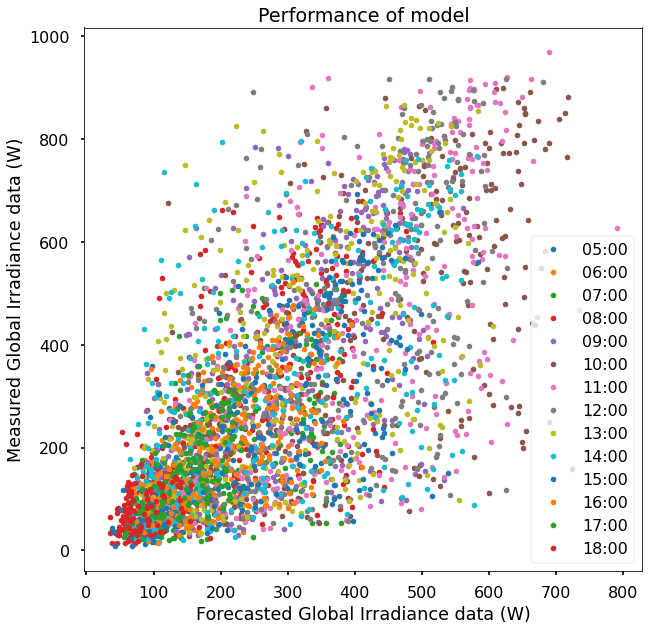

In [117]:
datans5['GLOBALPRED']=model5.predict(Xns5)
dataGLOBALPREDP5=datans5.loc[datans5.index < '2016-08-20'] 
dataGLOBALDATAP5=datans5.loc[datans5.index > '2016-04-20'] #se auto pao mia mera meta
dataGLOBALDATAP5['newvar']=dataGLOBALPREDP5.GLOBALPRED

datans6['GLOBALPRED']=model6.predict(Xns6)
dataGLOBALPREDP6=datans6.loc[datans6.index < '2016-10-02'] 
dataGLOBALDATAP6=datans6.loc[datans6.index > '2016-03-22'] #se auto pao mia mera meta
dataGLOBALDATAP6['newvar']=dataGLOBALPREDP6.GLOBALPRED

datans7['GLOBALPRED']=model7.predict(Xns7)
dataGLOBALPREDP7=datans7.loc[datans7.index < '2016-11-06'] 
dataGLOBALDATAP7=datans7.loc[datans7.index > '2016-02-24'] #se auto pao mia mera meta
dataGLOBALDATAP7['newvar']=dataGLOBALPREDP7.GLOBALPRED

datans8['GLOBALPRED']=model8.predict(Xns8)
dataGLOBALPREDP8=datans8.loc[datans8.index < '2016-12-23'] 
dataGLOBALDATAP8=datans8.loc[datans8.index > '2016-01-09'] #se auto pao mia mera meta
dataGLOBALDATAP8['newvar']=dataGLOBALPREDP8.GLOBALPRED

datans9['GLOBALPRED']=model9.predict(Xns9)
dataGLOBALPREDP9=datans9.loc[datans9.index < '2016-12-31'] 
dataGLOBALDATAP9=datans9.loc[datans9.index > '2016-01-02'] #se auto pao mia mera meta
dataGLOBALDATAP9['newvar']=dataGLOBALPREDP9.GLOBALPRED

datans10['GLOBALPRED']=model10.predict(Xns10)
dataGLOBALPREDP10=datans10.loc[datans10.index < '2016-12-31'] 
dataGLOBALDATAP10=datans10.loc[datans10.index > '2016-01-02'] #se auto pao mia mera meta
dataGLOBALDATAP10['newvar']=dataGLOBALPREDP10.GLOBALPRED

datans11['GLOBALPRED']=model11.predict(Xns11)
dataGLOBALPREDP11=datans11.loc[datans11.index < '2016-12-31'] 
dataGLOBALDATAP11=datans11.loc[datans11.index > '2016-01-02'] #se auto pao mia mera meta
dataGLOBALDATAP11['newvar']=dataGLOBALPREDP11.GLOBALPRED

datans12['GLOBALPRED']=model12.predict(Xns12)
dataGLOBALPREDP12=datans12.loc[datans12.index < '2016-12-31'] 
dataGLOBALDATAP12=datans12.loc[datans12.index > '2016-01-02'] #se auto pao mia mera meta
dataGLOBALDATAP12['newvar']=dataGLOBALPREDP12.GLOBALPRED

datans13['GLOBALPRED']=model13.predict(Xns13)
dataGLOBALPREDP13=datans13.loc[datans13.index < '2016-12-31'] 
dataGLOBALDATAP13=datans13.loc[datans13.index > '2016-01-02'] #se auto pao mia mera meta
dataGLOBALDATAP13['newvar']=dataGLOBALPREDP13.GLOBALPRED

datans14['GLOBALPRED']=model14.predict(Xns14)
dataGLOBALPREDP14=datans14.loc[datans14.index < '2016-12-31'] 
dataGLOBALDATAP14=datans14.loc[datans14.index > '2016-01-04'] #se auto pao mia mera meta
dataGLOBALDATAP14['newvar']=dataGLOBALPREDP14.GLOBALPRED

datans15['GLOBALPRED']=model15.predict(Xns15)
dataGLOBALPREDP15=datans15.loc[datans15.index < '2016-11-11'] 
dataGLOBALDATAP15=datans15.loc[datans15.index > '2016-01-12'] #se auto pao mia mera meta
dataGLOBALDATAP15['newvar']=dataGLOBALPREDP15.GLOBALPRED

datans16['GLOBALPRED']=model16.predict(Xns16)
dataGLOBALPREDP16=datans16.loc[datans16.index < '2016-10-12'] 
dataGLOBALDATAP16=datans16.loc[datans16.index > '2016-02-15'] #se auto pao mia mera meta
dataGLOBALDATAP16['newvar']=dataGLOBALPREDP16.GLOBALPRED

datans17['GLOBALPRED']=model17.predict(Xns17)
dataGLOBALPREDP17=datans17.loc[datans17.index < '2016-09-13'] 
dataGLOBALDATAP17=datans17.loc[datans17.index > '2016-03-22'] #se auto pao mia mera meta
dataGLOBALDATAP17['newvar']=dataGLOBALPREDP17.GLOBALPRED

datans18['GLOBALPRED']=model18.predict(Xns18)
dataGLOBALPREDP18=datans18.loc[datans18.index < '2016-08-13'] 
dataGLOBALDATAP18=datans18.loc[datans18.index > '2016-05-04'] #se auto pao mia mera meta
dataGLOBALDATAP18['newvar']=dataGLOBALPREDP18.GLOBALPRED

ax=plt.figure(figsize=(10,10))

plt.plot(dataGLOBALPREDP5.GLOBALPRED,dataGLOBALDATAP5.GLOBAL,linestyle='none',marker='.')
plt.plot(dataGLOBALPREDP6.GLOBALPRED,dataGLOBALDATAP6.GLOBAL,linestyle='none',marker='.')
plt.plot(dataGLOBALPREDP7.GLOBALPRED,dataGLOBALDATAP7.GLOBAL,linestyle='none',marker='.')
plt.plot(dataGLOBALPREDP8.GLOBALPRED,dataGLOBALDATAP8.GLOBAL,linestyle='none',marker='.')
plt.plot(dataGLOBALPREDP9.GLOBALPRED,dataGLOBALDATAP9.GLOBAL,linestyle='none',marker='.')
plt.plot(dataGLOBALPREDP10.GLOBALPRED,dataGLOBALDATAP10.GLOBAL,linestyle='none',marker='.')
plt.plot(dataGLOBALPREDP11.GLOBALPRED,dataGLOBALDATAP11.GLOBAL,linestyle='none',marker='.')
plt.plot(dataGLOBALPREDP12.GLOBALPRED,dataGLOBALDATAP12.GLOBAL,linestyle='none',marker='.')
plt.plot(dataGLOBALPREDP13.GLOBALPRED,dataGLOBALDATAP13.GLOBAL,linestyle='none',marker='.')
plt.plot(dataGLOBALPREDP14.GLOBALPRED,dataGLOBALDATAP14.GLOBAL,linestyle='none',marker='.')
plt.plot(dataGLOBALPREDP15.GLOBALPRED,dataGLOBALDATAP15.GLOBAL,linestyle='none',marker='.')
plt.plot(dataGLOBALPREDP16.GLOBALPRED,dataGLOBALDATAP16.GLOBAL,linestyle='none',marker='.')
plt.plot(dataGLOBALPREDP17.GLOBALPRED,dataGLOBALDATAP17.GLOBAL,linestyle='none',marker='.')
plt.plot(dataGLOBALPREDP18.GLOBALPRED,dataGLOBALDATAP18.GLOBAL,linestyle='none',marker='.')
# plt.plot(datans.GLOBALPRED,datans.GLOBAL,linestyle='none',marker='.')

plt.legend(['05:00', '06:00','07:00', '08:00','09:00', '10:00','11:00', '12:00','13:00', '14:00','15:00', '16:00','17:00', '18:00'])
plt.xlabel('Forecasted Global Irradiance data (W)')
plt.ylabel('Measured Global Irradiance data (W)')
plt.title('Performance of model')

In [120]:
selected_columnsns = datans[["mT2","mRH","GLOBAL","SAA","SZA","DIRECT","DIFFUSE"]]
new_datans = selected_columnsns.copy()
Xnew_data = new_datans[["mT2","mRH","GLOBAL","SAA","SZA","DIRECT","DIFFUSE"]]
eleos=[None]*len(new_datans);

for l in range (0, len(new_datans)):
    if new_datans.index.hour[l] == 5:
        eleos[l] = model5.predict(Xnew_data)[l]
    elif new_datans.index.hour[l] == 6:
        eleos[l] = model6.predict(Xnew_data)[l]
    elif new_datans.index.hour[l] == 7:
        eleos[l] = model7.predict(Xnew_data)[l] 
    elif new_datans.index.hour[l] == 8:
        eleos[l] = model8.predict(Xnew_data)[l]            
    elif new_datans.index.hour[l] == 9:
        eleos[l] = model9.predict(Xnew_data)[l]            
    elif new_datans.index.hour[l] == 10:
        eleos[l] = model10.predict(Xnew_data)[l]           
    elif new_datans.index.hour[l] == 11:
        eleos[l] = model11.predict(Xnew_data)[l]            
    elif new_datans.index.hour[l] == 12:
        eleos[l] = model12.predict(Xnew_data)[l]            
    elif new_datans.index.hour[l] == 13:
        eleos[l] = model13.predict(Xnew_data)[l]            
    elif new_datans.index.hour[l] == 14:
        eleos[l] = model14.predict(Xnew_data)[l]            
    elif new_datans.index.hour[l] == 15:
        eleos[l] = model15.predict(Xnew_data)[l]            
    elif new_datans.index.hour[l] == 16:
        eleos[l] = model16.predict(Xnew_data)[l]            
    elif new_datans.index.hour[l] == 17:
        eleos[l] = model17.predict(Xnew_data)[l]            
    elif new_datans.index.hour[l] == 18:
        eleos[l] = model18.predict(Xnew_data)[l]            
print()
# print(eleos)
new_datans['GLOBALPRED']=eleos
new_datans
# datans.GLOBALPRED







# a=datans.loc[(datans.index < '2016-05-28') & (datans.index > '2016-05-17')]
# b=datans.loc[(datans.index < '2016-05-29') & (datans.index > '2016-05-18')]

# aa=[None] * (len(a));
# for l in range (0, len(a)):
#     aa[l] = a.GLOBALPRED[l] 
# print()

# bb=[None] * (len(b));
# for l in range (0, len(b)):
#     bb[l] = b.GLOBAL[l] 
# print()

# fig = plt.subplots(figsize=(30,7))
# plt.plot(aa,linestyle='solid')
# plt.plot(bb,linestyle='solid')
# plt.xlabel('Date: 17/05/2016 - 27/05/2016')
# plt.ylabel('Global Irradiance data (W)')
# plt.title('Performance of model')
# plt.legend(['Forecasted Global Irradiance','Measured Global Irradiance'])

# a1=datans.loc[(datans.index < '2016-02-28') & (datans.index > '2016-02-17')]
# b1=datans.loc[(datans.index < '2016-02-29') & (datans.index > '2016-02-18')]

# aa1=[None] * (len(a1));
# for l in range (0, len(a1)):
#     aa1[l] = a1.GLOBALPRED[l] 
# print()

# bb1=[None] * (len(b1));
# for l in range (0, len(b1)):
#     bb1[l] = b1.GLOBAL[l] 
# print()

# fig = plt.subplots(figsize=(30,7))
# plt.plot(aa1,linestyle='solid')
# plt.plot(bb1,linestyle='solid')
# plt.xlabel('Date: 17/02/2016 - 27/02/2016')
# plt.ylabel('Global Irradiance data (W)')
# plt.title('Performance of model')
# plt.legend(['Forecasted Global Irradiance','Measured Global Irradiance'])

# a2=datans.loc[(datans.index < '2016-08-28') & (datans.index > '2016-08-17')]
# b2=datans.loc[(datans.index < '2016-08-29') & (datans.index > '2016-08-18')]

# aa2=[None] * (len(a2));
# for l in range (0, len(a2)):
#     aa2[l] = a2.GLOBALPRED[l] 
# print()

# bb2=[None] * (len(b2));
# for l in range (0, len(b2)):
#     bb2[l] = b2.GLOBAL[l] 
# print()

# fig = plt.subplots(figsize=(30,7))
# plt.plot(aa2,linestyle='solid')
# plt.plot(bb2,linestyle='solid')
# plt.xlabel('Date: 17/08/2016 - 27/08/2016')
# plt.ylabel('Global Irradiance data (W)')
# plt.title('Performance of model')
# plt.legend(['Forecasted Global Irradiance','Measured Global Irradiance'])

# a3=datans.loc[(datans.index < '2016-11-28') & (datans.index > '2016-11-17')]
# b3=datans.loc[(datans.index < '2016-11-29') & (datans.index > '2016-11-18')]

# aa3=[None] * (len(a3));
# for l in range (0, len(a3)):
#     aa3[l] = a3.GLOBALPRED[l] 
# print()

# bb3=[None] * (len(b3));
# for l in range (0, len(b3)):
#     bb3[l] = b3.GLOBAL[l] 
# print()

# fig = plt.subplots(figsize=(30,7))
# plt.plot(aa3,linestyle='solid')
# plt.plot(bb3,linestyle='solid')
# plt.xlabel('Date: 17/11/2016 - 27/11/2016')
# plt.ylabel('Global Irradiance data (W)')
# plt.title('Performance of model')
# plt.legend(['Forecasted Global Irradiance','Measured Global Irradiance'])

,mT2,mRH,GLOBAL,SAA,SZA,DIRECT,DIFFUSE,GLOBALPRED
date,,,,,,,,
2016-01-01 09:00:00,5.0,98.1,43.1,-33.5,78.7,0.1,43.0,[91.71304]
2016-01-01 10:00:00,4.8,98.4,59.6,-20.1,74.3,0.1,59.6,[120.13436]
2016-01-01 11:00:00,5.3,98.6,62.4,-5.9,72.0,0.2,62.5,[151.43423]
2016-01-01 12:00:00,6.0,98.6,56.0,8.6,72.3,0.2,56.1,[134.67589]
2016-01-01 13:00:00,6.3,98.2,62.9,22.7,74.9,0.4,62.9,[99.05376]
...,...,...,...,...,...,...,...,...
2016-12-31 10:00:00,-3.9,94.9,132.5,-20.1,74.3,1.5,132.7,[198.16565]
2016-12-31 11:00:00,-3.7,94.8,107.1,-5.9,72.1,0.3,107.5,[196.8013]
2016-12-31 12:00:00,-3.3,95.1,92.7,8.6,72.3,0.2,93.1,[162.43834]


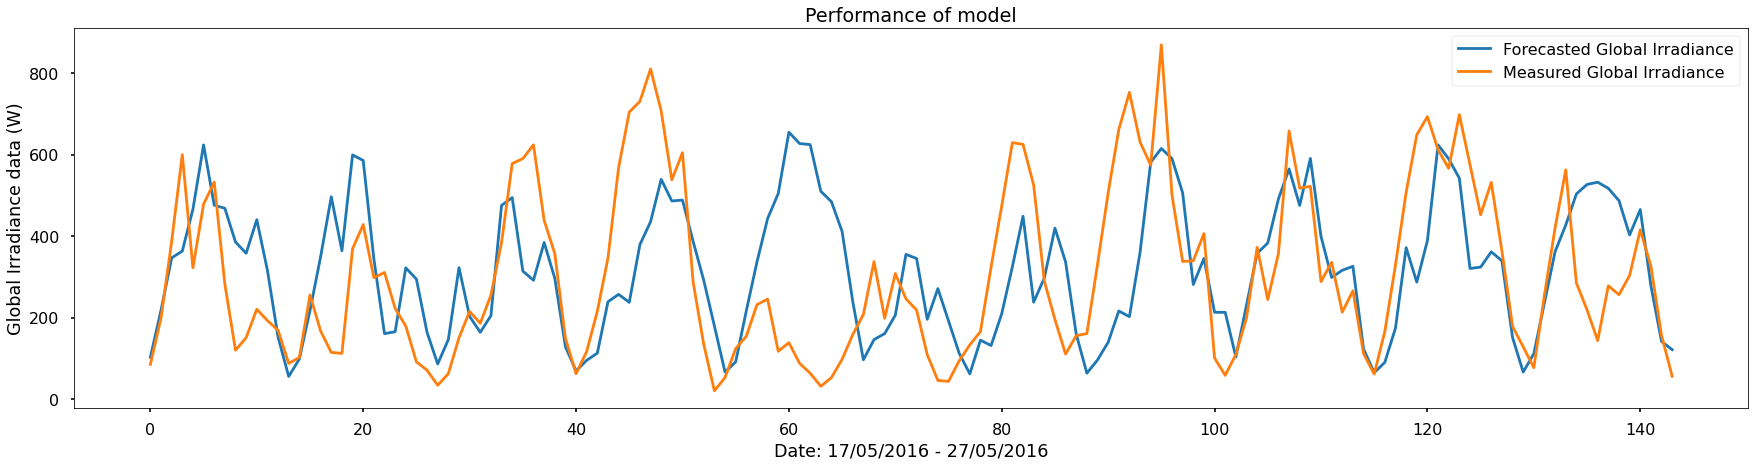

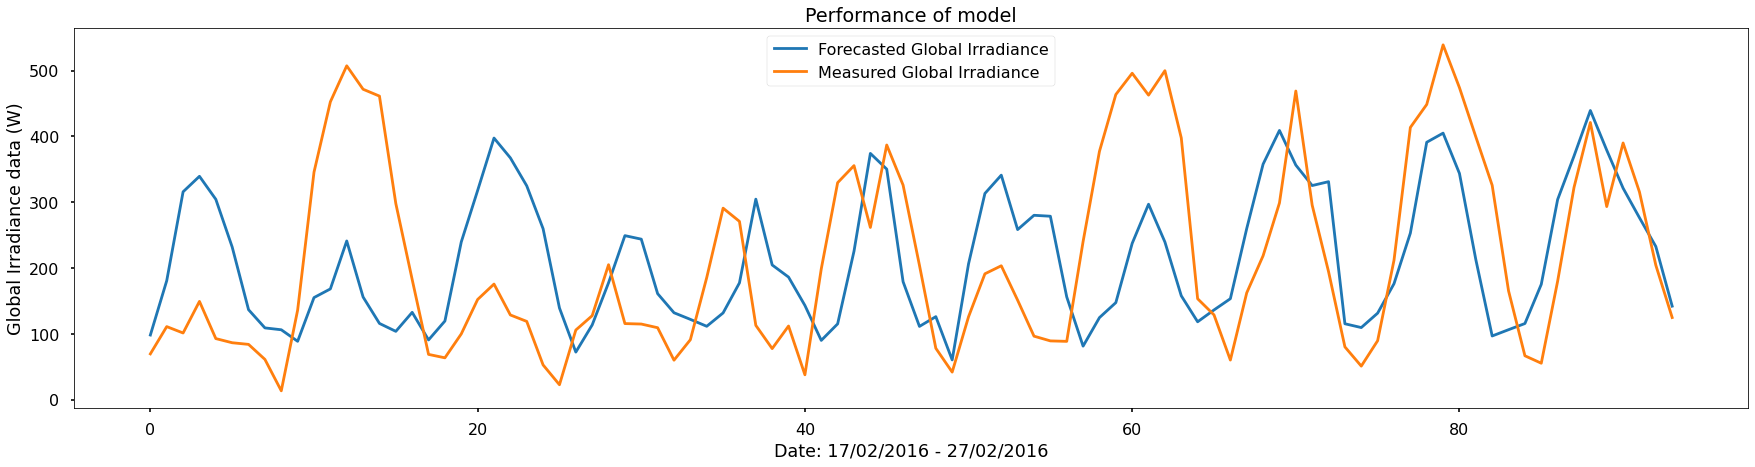

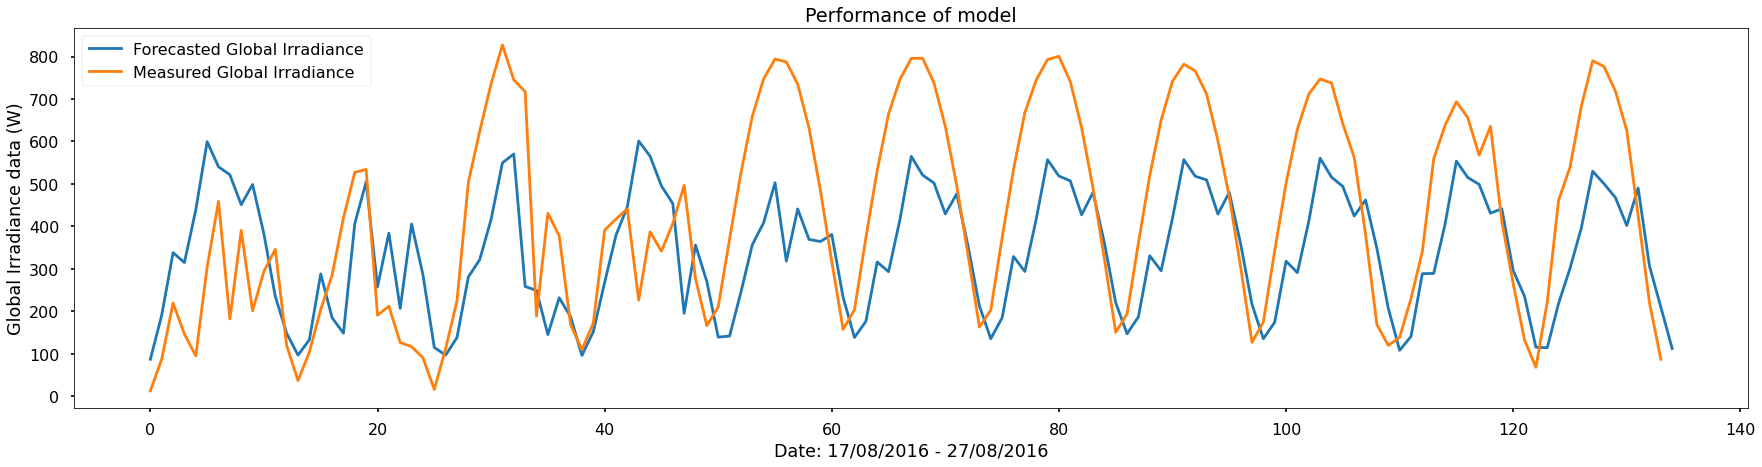

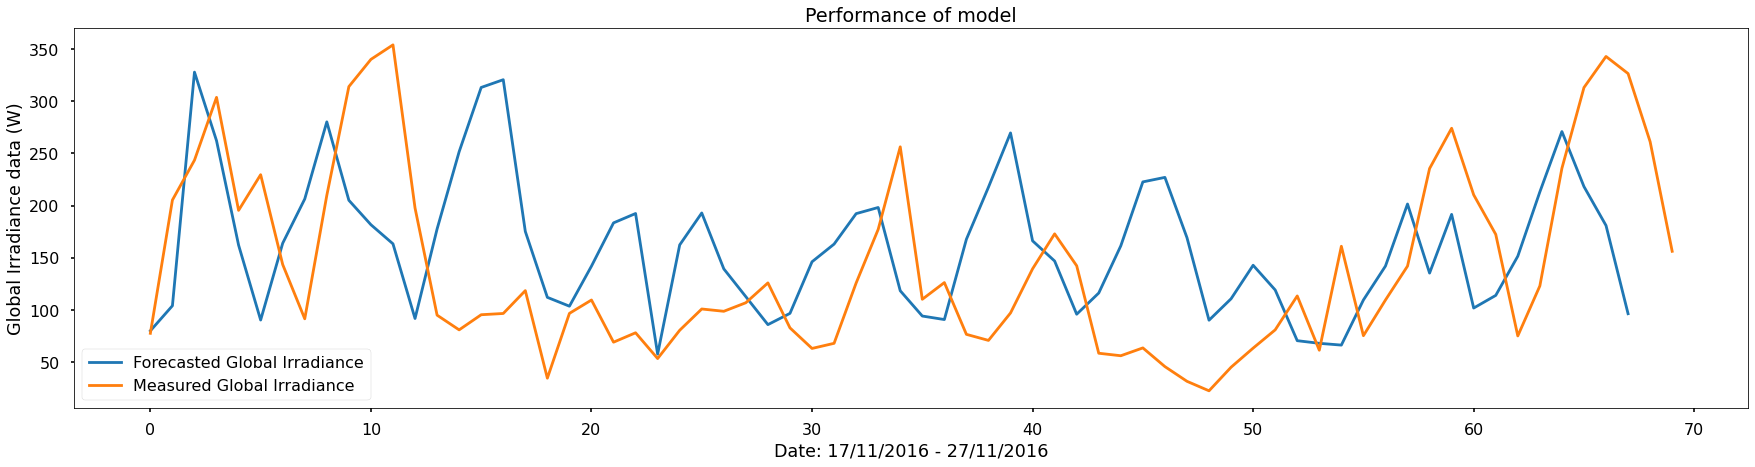

In [121]:
a=new_datans.loc[(new_datans.index < '2016-05-28') & (new_datans.index > '2016-05-17')]
b=new_datans.loc[(new_datans.index < '2016-05-29') & (new_datans.index > '2016-05-18')]

aa=[None] * (len(a));
for l in range (0, len(a)):
    aa[l] = a.GLOBALPRED[l] 
print()

bb=[None] * (len(b));
for l in range (0, len(b)):
    bb[l] = b.GLOBAL[l] 
print()

fig = plt.subplots(figsize=(30,7))
plt.plot(aa,linestyle='solid')
plt.plot(bb,linestyle='solid')
plt.xlabel('Date: 17/05/2016 - 27/05/2016')
plt.ylabel('Global Irradiance data (W)')
plt.title('Performance of model')
plt.legend(['Forecasted Global Irradiance','Measured Global Irradiance'])

a1=new_datans.loc[(new_datans.index < '2016-02-28') & (new_datans.index > '2016-02-17')]
b1=new_datans.loc[(new_datans.index < '2016-02-29') & (new_datans.index > '2016-02-18')]

aa1=[None] * (len(a1));
for l in range (0, len(a1)):
    aa1[l] = a1.GLOBALPRED[l] 
print()

bb1=[None] * (len(b1));
for l in range (0, len(b1)):
    bb1[l] = b1.GLOBAL[l] 
print()

fig = plt.subplots(figsize=(30,7))
plt.plot(aa1,linestyle='solid')
plt.plot(bb1,linestyle='solid')
plt.xlabel('Date: 17/02/2016 - 27/02/2016')
plt.ylabel('Global Irradiance data (W)')
plt.title('Performance of model')
plt.legend(['Forecasted Global Irradiance','Measured Global Irradiance'])

a2=new_datans.loc[(new_datans.index < '2016-08-28') & (new_datans.index > '2016-08-17')]
b2=new_datans.loc[(new_datans.index < '2016-08-29') & (new_datans.index > '2016-08-18')]

aa2=[None] * (len(a2));
for l in range (0, len(a2)):
    aa2[l] = a2.GLOBALPRED[l] 
print()

bb2=[None] * (len(b2));
for l in range (0, len(b2)):
    bb2[l] = b2.GLOBAL[l] 
print()

fig = plt.subplots(figsize=(30,7))
plt.plot(aa2,linestyle='solid')
plt.plot(bb2,linestyle='solid')
plt.xlabel('Date: 17/08/2016 - 27/08/2016')
plt.ylabel('Global Irradiance data (W)')
plt.title('Performance of model')
plt.legend(['Forecasted Global Irradiance','Measured Global Irradiance'])

a3=new_datans.loc[(new_datans.index < '2016-11-28') & (new_datans.index > '2016-11-17')]
b3=new_datans.loc[(new_datans.index < '2016-11-29') & (new_datans.index > '2016-11-18')]

aa3=[None] * (len(a3));
for l in range (0, len(a3)):
    aa3[l] = a3.GLOBALPRED[l] 
print()

bb3=[None] * (len(b3));
for l in range (0, len(b3)):
    bb3[l] = b3.GLOBAL[l] 
print()

fig = plt.subplots(figsize=(30,7))
plt.plot(aa3,linestyle='solid')
plt.plot(bb3,linestyle='solid')
plt.xlabel('Date: 17/11/2016 - 27/11/2016')
plt.ylabel('Global Irradiance data (W)')
plt.title('Performance of model')
plt.legend(['Forecasted Global Irradiance','Measured Global Irradiance'])